# Social Network Analytics Project
### Analysis of Inter-community football Conflcits in subreddit

#### Team Members :
##### Dinesh Sathyanarayanan (01FB16ECS114)
##### Deekshith G (01FB16ECS106)
##### Aswath S (01FB16ECS080)

In [1]:
"""
CONFLICTS WITH CONTROVERSIALITY - 2017 DATA (CSV FORMAT)

This file intends to find possible conflicts between communities (weight and direction) using the
"controversiality" attribute given in the reddit data.


1. Our goal is to construct a conflict graph to analyse conflict properties and types.
2. To do that, we must find out social/anti-social homes for each user.
3. We do not have upvote / downvote details to easily derive conflicts.
4. So we initially planned to use sentiment of the parent comment 
    as well as the sentiments of the replies to come up with a decision.
    We have finished the preprocessing to do such an analysis but there are problems to consider like 
    How many children do we take  and to what depth ? 
    Also, negative sentiment does not mean controversy all the time.
    But this method could help getting more results than what we are currently using
5. In this file, we instead use the controversiality property given in the subreddit data
6. NOTE : All controversial comments do not cause conflicts. 
7. So the first step is to link a controvrsial comment to a subreddit
8. We first focus on the "soccer" subreddit vs all other subreddits
9. Conflicts more likely to occur directing outwards from soccer as 
    a. More number of users.
    b. Fans of most football clubs comment on this subreddit
10. After linking (direction of edge done), we must assign weights to the links
11. Stat: For each month, on average, 2% of the comments tend to have controversy in each subreddit. 
12. Hence an even lesser percentage of comments cause conflcits.

From the below type prefixes, we use t1_ and t3_, which are for comments and links

The other files are not too well commented, due to time constraints

"""

#type prefixes
#t1_	Comment
#t2_	Account
#t3_	Link
#t4_	Message
#t5_	Subreddit
#t6_	Award


# IMPORTS
import json
from operator import itemgetter 
import pandas as pd
import os
from textblob import TextBlob
import pylab
import matplotlib.pyplot as plt
import networkx as nx
from itertools import permutations

In [2]:
# This csv file contents is ordered by subreddit name

# READ CSV DATA + PREPROCESSING
RC_2017_LIST = []

# Retrieve 12 csv files for the 2017 data
FOLDER = "./monthly_data/"
FILES = os.listdir(FOLDER)

# Store all month csv files as separate dataframes
# IMPORTANT - Store only controversial comments

# Remove unwanted files
CSV_FILES = [file for file in FILES if "~lock" not in file]
print(CSV_FILES)
for file in CSV_FILES:
    RC_2017_month = pd.read_csv(FOLDER+file)
    RC_2017_month = RC_2017_month[["author", "body", "controversiality", "id", "link_id",
                                   "parent_id", "score", "subreddit_id", "subreddit"]]
    RC_2017_LIST.append(RC_2017_month[RC_2017_month["controversiality"]>=1])

['RC_2017-01-GroupPost.csv', 'RC_2017-02-GroupPost.csv', 'RC_2017-03-GroupPost.csv', 'RC_2017-04-GroupPost.csv', 'RC_2017-05-GroupPost.csv', 'RC_2017-06-GroupPost.csv', 'RC_2017-07-GroupPost.csv', 'RC_2017-08-GroupPost.csv', 'RC_2017-09-GroupPost.csv', 'RC_2017-10-GroupPost.csv', 'RC_2017-11-GroupPost.csv', 'RC_2017-12-GroupPost.csv']


C:\Users\Dinesh\Anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Dinesh\Anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Dinesh\Anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (5,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Dinesh\Anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (4,5,10,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivi

In [3]:
RC_2017_LIST[1]

,author,body,controversiality,id,link_id,parent_id,score,subreddit_id,subreddit
687,DumbledoresFerrari,and 0 player of the season awards,1,dd65j5k,t3_5ra41q,t1_dd60j2s,-1,t5_2qi58,soccer
689,AMBsFather,AfuckingMEN,1,dd67z8q,t3_5ra41q,t1_dd5l8qk,2,t5_2qi58,soccer
731,TheMayorOfHounslow,shat on Madrid,1,dd6jxmm,t3_5rahaw,t3_5rahaw,0,t5_2qi58,soccer
747,CallingYong,"Hey, he ain't just some bloke, he's superbowl ...",1,dd62o28,t3_5rajm0,t1_dd60piz,-1,t5_2qi58,soccer
748,tinoasprilla,Sky Sports Network maybe,1,dd62yfz,t3_5rajm0,t1_dd5wcss,1,t5_2qi58,soccer
...,...,...,...,...,...,...,...,...,...
641719,BrianThatDude,Gunner here. Wtf? No loyalty. What a joke. He ...,1,de4klpc,t3_5vsq6c,t3_5vsq6c,5,t5_2ukrz,lcfc
642032,tuai-,"It's terrible, and I'm getting fed up with peo...",1,dda4dui,t3_5rt00k,t1_dda2kih,0,t5_2v6bc,atletico
642039,EricN9,How do you know she didnt attack him first? Oh...,1,ddace17,t3_5rt00k,t1_dda4dui,2,t5_2v6bc,atletico
642935,HandsomePhantom,"tbh honest that looks like a clown outfit, wha...",1,dds1bg3,t3_5u67cr,t3_5u67cr,0,t5_2vvzn,FCInterMilan


In [4]:
RC_2017_LIST[1].keys()

Index(['author', 'body', 'controversiality', 'id', 'link_id', 'parent_id',
       'score', 'subreddit_id', 'subreddit'],
      dtype='object')

In [5]:
# Various subreddits and the club names
subreddits_order = ["soccer", "Gunners", "reddevils", 
                    "LiverpoolFC", "chelseafc", "coys", 
                    "Barca", "realmadrid", "MCFC", 
                    "fcbayern", "borussiadortmund", 
                    "everton", "NUFC", "ACMilan", "Juve", 
                    "Hammers", "avfc", "CelticFC", "SaintsFC", 
                    "ASRoma", "benfica", "psg", "lcfc", 
                    "atletico", "FCInterMilan"]
names_order = ["Soccer", "Arsenal", "Manchester_United", 
               "Liverpool", "Chelsea", "Tottenham", 
               "Barca", "Real_Madrid", "Manchester_City", 
               "Bayern", "Dortmund", "Everton", "Newcastle",
               "AC_Milan", "Juventus", "West_Ham", "Aston_Villa", 
               "Celtic", "Southampton", "Roma", "Benfica", "PSG", 
               "Leicester", "Atletico_Madrid", "InterMilan"]
months = ["January", "February", "March", "April", "May", "June", "July", 
          "August", "September", "October", "November", "December"]

In [7]:
# Number of links in each month data(meaning number of comment threads)
for i, df in enumerate(RC_2017_LIST):
    print(months[i], (len(df["link_id"].unique()), len(df)))

January (5214, 24581)
February (4514, 23486)
March (5291, 29218)
April (5927, 34325)
May (6373, 33575)
June (6514, 31134)
July (8138, 38357)
August (10531, 50339)
September (7199, 38944)
October (6098, 31987)
November (5585, 29482)
December (6841, 41408)


In [8]:
# We can see a spike in comment counts (no. of links above...) from July onwards
# This is due to the start of UEFA Champions league during early JULY 2017

In [9]:
# First choose which subreddit you're taking
# I'm taking "soccer" first

source_subreddit_chosen = subreddits_order[0]

# Others are the targets
target_subreddits_chosen = subreddits_order[1:]

# We intend to direct and weight conflicts from this source to all targets first.
# This process will then be performed for all subreddits

In [10]:
# Some observations while manually checking controversial comments
# Most controversial comments in the club subreddits (everything but "soccer") 
# tend to be against their own community rather than oter communities.
# So we'll identify those too. Not just inter-community
# Conflits within communities are more prominentas people tend to have a highly critical
# view of the team / players when they lose matches

In [11]:
keywords_dictionary = json.load(open("dictionary.json", "r", encoding="utf8"))

In [12]:
keywords_dictionary["reddevils"]

['De Gea',
 'Dean Henderson',
 'Joel Pereira',
 'Kieran O Hara',
 'Sergio Romero',
 'Eric Bailly',
 'Daley Blind',
 'Matteo Darmian',
 'Timothy Fosu-Mensah',
 'Phil Jones',
 'Demetri Mitchell',
 'Marcos Rojo',
 'Luke Shaw',
 'Chris Smalling',
 'Antonio Valencia',
 'Ander Herrera',
 'Michael Carrick',
 'Marouane Fellaini',
 'Angel Gomes',
 'Josh Harrop',
 'Jesse Lingard',
 'Mata',
 'Scott McTominay',
 'Henrikh Mkhitaryan',
 'Paul Pogba',
 'Axel Tuanzebe',
 'Matty Willock',
 'Ashley Young',
 'Zachary Dearnley',
 'Zlatan Ibrahimović',
 'Anthony Martial',
 'Marcus Rashford',
 'Wayne Rooney',
 'José Mourinho',
 'Rui Faria',
 'Silvino',
 'Emilio Álvarez',
 'Manchester United Football Club',
 'The Red Devils',
 'Sir Matt Busby Way',
 'Old Trafford',
 'Ole Gunnar Solskjær',
 'Louis van Gaal',
 'Ryan Giggs',
 'David Moyes',
 'Alex Ferguson',
 'Ron Atkinson',
 'Dave Sexton',
 'Tommy Docherty',
 'Frank O Farrell',
 'Matt Busby',
 'Wilf McGuinness',
 'Jimmy Murphy',
 'Matt Busby',
 'Walter Crickme

In [14]:
# Now, conflicts could be directed towards the community itself or the players of that community
# If it's towards players, it is harder to find which community as many players have the same first name
# And users comment mostly the first name of the player
# So, we'll first check out the direction from "soccer" to "LiverpoolFC". 
# We haven't done conflicts towards Players specifically due to lack of time

In [15]:
for i, df_month in enumerate(RC_2017_LIST):
    soccer_sub = df_month[df_month["subreddit"]=="soccer"]
    if(i==0):
        soccer_subreddit_comments_df = soccer_sub
    else:
        soccer_subreddit_comments_df = soccer_subreddit_comments_df.append(soccer_sub)

In [16]:
soccer_subreddit_comments_df

,author,body,controversiality,id,link_id,parent_id,score,subreddit_id,subreddit
764,oranbhoy,if only the Rangers fans were so swift to poin...,1,dbuslf3,t3_5l9g6b,t3_5l9g6b,2,t5_2qi58,soccer
777,Mind43dom,Rangers vs Celtic.\n\nCeltic rarely ever respe...,1,dbuvsoi,t3_5l9g6b,t1_dbuid4j,-2,t5_2qi58,soccer
851,MHCR,With the players Prandelli had at his disposal...,1,dbuwcmu,t3_5l9pyr,t3_5l9pyr,0,t5_2qi58,soccer
959,supahsonicboom,Wow I watched the video too haha,1,dbv6dys,t3_5l9ysl,t1_dbu9h3s,-3,t5_2qi58,soccer
976,PigeonNipples,The Grand Tour is comprised almost entirely of...,1,dbup1uk,t3_5la4aw,t1_dbubu7w,2,t5_2qi58,soccer
...,...,...,...,...,...,...,...,...,...
550339,RuralHuman,"Didn't watch De Gea at all, but he must be the...",1,ds0mc5i,t3_7nbnfh,t3_7nbnfh,3,t5_2qi58,soccer
550340,stevenmadden,Oh I completely forgot about Ederson. He's abo...,1,ds0mfft,t3_7nbnfh,t1_ds0ma2q,3,t5_2qi58,soccer
550342,Babayoko,Agree. As a keeper myself i think De Gea playi...,1,ds0mie9,t3_7nbnfh,t1_ds0m3ol,-2,t5_2qi58,soccer
550345,jeevesyboi,With a strong defence in front and not as big ...,1,ds0mlu3,t3_7nbnfh,t1_ds0lujt,6,t5_2qi58,soccer


In [17]:
# All the subreddits whose keywords we have gathered
# Keywords : Names of players, coaches, stadiums, short forms for each club etc.
for keyword in keywords_dictionary:
    print(keyword)

LiverpoolFC
chelseafc
Barca
realmadrid
ACMilan
reddevils
mcfc
gunners
hammers
coys


In [20]:
# Pinting out some comments that are negative and controversial towards "LiverpoolFC" in "Soccer"
sum1 = 0
for i, body in enumerate(list(soccer_subreddit_comments_df["body"])):
    keyword_count = 0
    for keyword in " ".join(keywords_dictionary["LiverpoolFC"]).split(" "):
        if(type(body)==str and keyword.lower() in body.lower()):
            keyword_count+=1
    if(keyword_count >= 5): # Can increase count - cause many teams may have players with same keywords
        print((keyword_count, TextBlob(body).sentiment.polarity, body))
        
        # Ignore positive comments or neutral
        if TextBlob(body).sentiment.polarity<0.2:
            sum1 = TextBlob(body).sentiment.polarity*keyword_count
        sentiment = TextBlob(body)

(7, 0.18247619047619051, "Well, physically Buli defenders aren't any better obviously, not like they can run faster, jump higher or anything, but german coaches and academies put very big emphasis on tactics. It has always been a defensive and tactical rather than flashy or offensive league and since Pep has arrived a couple years ago the standard catapulted even higher. Coaches like Tuchel, Nagelsmann, Kovac, Stöger, Hasenhüttl, Dardai, Schuster or Weinzierl are incredible tactical experts imo.\n\nDiscounting the offensive, possession-based powerhouses with individually brilliant players like Bayern or Dortmund, it's all about being defensively compact, tight defending, quick transitions, combinations and counterattacks. Imagine a league full of mini Atletico Madrids basically. \n\nAnd as far as standard for CBs goes, since I'm mostly just following Liverpool because all their germans, I do admit I was surprised how well they did and it puts some things into perspective for me persona

(5, 0.0, "It isn't simple, anyone who watched the CWC saw that video refereeing has its disadvantages... I agree that we need to implement it though.")
(5, 0.04583333333333334, "You might have done well againt United but what about the clear cut red cards you should have got when playing against United earlier in the season? Adrian's foul on Zlatan and Reid's studs slicing Rooney's cheek. That was a penalty. Forgot the other clear incident. I did not see anyone talk about the Refs much during that time. ")
(8, 0.23939393939393938, "I think the crucial factor is that shape at the base of the Chelsea team:\n\nCahill - Luiz - Azpilicueta\n\n      Kante - Matic\n\nWhilst Matip, Lovren or Klavan might conceivably be players of the required quality to win a title, without adequate shielding, they are being asked to do the near-impossible. I don't think they're the very best around, but had they someone with the energy and awareness of Kante ahead of them, who was specifically tasked with dis

(5, 0.24047619047619048, 'In my experience, (which is obviously anecdotal)\n\nManU fans tend to be the most uneducated fans.  80% of people who identify as "ManU fans" in the US, do it because they want to like soccer and choose a team, and that\'s the team they\'ve heard of.\n\nSo basically, you get fans who may watch a couple matches a year and aren\'t THAT into it.\n\nLiverpool, Chelsea, Tott, Arsenal...these are typically fans who have actually stopped to analyze which team they should choose.\n\nAnd City...well ok, I have yet to meet a true City fan in the US.  I\'m sure some exist somewhere.')
(5, -0.3138888888888889, 'Neymar is very flashy and knows how to take advantage of slower defenders. Barcelona is sucking hard though. They only dropped Dani Alves yet keep losing matches.')
(5, -0.5, 'https://www.reddit.com/r/soccer/comments/5kc91i/rsoccer_world_football_awards_voting_polls/\n\n11 days ago\n\nand it was prob not stickied, i didnt bother voting as this is completely irrelev

(5, -0.3547619047619048, '&gt;Bayern president Uli Hoeness – upset by China’s top clubs taking an unfair financial advantage. “It’s sick, it’s just sick. I just hope it doesn’t turn out as bad as it looks at the moment.”\n\n')
(5, 0.13935185185185184, 'Bayern competes globally, and they also sign their players globally and not just from their league. Bayern competed with United for Vidal, Thiago, Pep or countless others, and these have decided for the lower paycheck in order to go there, didnt they? I can guarantee Vidal for example would be among PL top earners had he chosen otherwise. I don\'t see how "having no domestic competition" as you say, mattered here.\n\nThe amount of players in their squad from Germany is no different than the amount of players that a spanish top club has from Spain, or an english top club has from England. And half of those are even from their own youth, another aspect that spares the finances here. And as I said, history is vastly overrated, Nottingham Fo

(6, -0.0666666666666667, "The fans should've booed him every game until the club were forced to sell him.\n\nI would never accept a killer in my team, any more than I would accept a paedophile (Adam Johnson).")
(5, 0.20416666666666666, "It wasn't just a MOTM performance though, it was voted as the best individual performance by a Liverpool player on /r/LiverpoolFC. I understand what you mean when you say players have good performances every now and then but often don't show it consistently, but he's only 23, he was the youngest starting player in the team tonight and has absolutely loads of time to improve, not to mention the fact that he was played out of position (at LB and CB) for almost the entire year under Rodgers which didn't help his development. ")
(5, -0.024489795918367346, "that's correct. the moronic directive didn't even want to renew him before starting the treble season.  \n\nthey hired aleix vidal after that season (during the sanction so he only started playing in janu

(10, 0.12298850574712644, 'Part 1:\n\nThe Premier League season was still in its infancy when Jose Mourinho filmed a charity “joke off” with the Liverpool comedian and supporter John Bishop, as part of a Channel 4 telethon for Stand Up To Cancer. Bishop and the Manchester United manager would take it in turns to tell a joke and the first person to laugh lost that round. Yet the funniest moment remains unseen by most. “OK, a wild card,” Mourinho tells Bishop. “When was the last time Liverpool won the league title?” Mourinho can barely finish his sentence he is laughing so hard as Bishop feigns outrage.\n\nA couple of prominent figures at United were recalling the episode this week ahead of Liverpool’s visit to Old Trafford on Sunday afternoon, when\xa0a 10th successive victory in all competitions for Mourinho’s sidewould carry them to within two points of\xa0their Merseyside rivals\xa0and rekindle hopes of a title charge that had seemed implausible just six weeks ago.\n\nIt is easy to f

(5, 0.21875, "Probably because I'm talking about united, although when talking about what a nice celebration it is I think taking about other similar celebrations is relevant. ")
(5, -0.16875000000000004, "I mean, everyone knew since the start of the season that you have a thin squad in quite a few positions. \n\n\nIf would not phrase the situation the way you have done, because your transfer board and Klopp didn't prepare for a very likely situation like this, and it's more a case of not being fully prepared than being royally fucked.\n\n\nEven the Matip situation should have been cleared asap. ")
(5, 0.12166666666666669, 'Do people think that is very relevant and therefore Hart is better? \n\nIIRC Hart conceded 4 goals from 7 shots in the euros.  \n\nEdit: holy shit getting downvoted for stating a fact. Ridiculous, hurhurhur its not a spicy Hart meme. ')
(5, 0.10703703703703704, "They do. It's recency bias. Hart has never been worldclass, Bravo has. The statistics even showed that ev

(6, 0.035833333333333314, "&gt;Self proclaimed biggest club in the world celebrated a draw at Anfield, after setting up like Plymouth.\n\nYou're either daft, or you didn't watch the game. We were the better side yesterday. You scored off of a penalty, while we scored off of an offside. One was legal, the other was not; but remember that you never even managed to score from open play — not even an offside goal. You got lucky that the ball brushed Pogba's hand.\n\nLastly, fuck off you mugs! Back to the meltdown that is /r/LiverpoolFC \n")
(5, -0.11818181818181818, "It is undeniably linked to Hillsborough, as well as Heysel. For decades we're had to deal with people telling our fanbase that we should just move on from Hillsborough and stop wallowing in victim-hood by campaigning for justice, back before it was widely accepted that the disaster was caused by severe police misconduct that had effectively been covered up. I've heard opposition fans start singing that song as a response to Li

(5, 0.2445, 'Imagine someone who earns £20,000 a year saying, "Doubling your salary from £100,000 to £200,000 a year won\'t make a huge difference in your quality of life. Stop being greedy."\n\nLike hell it won\'t increase one\'s quality of life. It means you could buy a much bigger house with more floors, a bigger garage with more cars, more servants, a bigger trust fund for the kids, a better private school for the kids, more extravagant holidays. I could go on.\n\nWhat you and other people ITT are lacking is knowledge of what doubling your salary gets you, even if you\'re earning millions a year. Even billionaires would love to double their net worth because it\'d mean they could invest in more companies or start more charitable programmes.\n\nSo, yes, a footballer going to China to get his wages doubled/tripled/quadrupled is exactly the same as someone on £12k/£40k/£80k/160k a year doubling their salary. Quality of life goes up regardless of if people in lower salary tiers can\'t 

(6, 0.4238095238095238, 'Imbula 18m, Lamela 30m, Wijnaldum 23m, Mane 35m, Firmino 35m, Slimani 25m, Xhaka 38m, Sissoko 29m, Bolasie 25m.... Payet is arguably better than all of them, older yes but better and easily worth more than most of them. If Payet was at a top team and leaving, no one would bat an eye at 30-35m')
(5, 0.025000000000000005, 'Jordan Henderson is better than Ozil, but the two players have almost nothing in common with each other in their play style. Baffling list this.')
(5, -0.05833333333333335, "...No I wasn't. I didn't say United fans are the only fans to downvote things they don't like, I might have said United fans are the worst at it which anyone on the sub can tell you is absolutely clear because there is so many of them. I never had a go at United fans for downvoting shit banter or downvoting people insulting their team or players. There is a massive difference between downvoting an irrelevant joke and downvoting someone saying that they don't agree that Vale

(5, 0.0, "Why are the commentators saying that Walker would have been sent off?  As soon as the ref plays advantage (which he does in letting Sterling take the shot) he can't then send off the player if he beings it back.")
(5, 0.0, "That's the reason r/soccer won't admit it's a handball, even though his arm only moved to that position as the ball fell to control it advantageously.")
(5, 0.0, 'He can play advantage, and after the play does not end in a goal that is when he should bring it back for a penalty and send of Kyle Walker.  ')
(5, 0.027777777777777776, 'I agree completely with this, I remember trying to bring this up earlier in the season with, I think it was Xhaka\'s, tactical foul. I got downvoted for it. \n\nOn one hand, I can understand the apparent commending of tactical fouls, but yeah, I\'ve always seen them as both sides of the same coin, in essence, "cheating" to gain an advantage. \n\nObviously, tactical fouls will nearly always result in a yellow, but it\'s weird to

(13, 0.0769704433497537, 'Christ....every single year I see this. How you don\'t understand that this type of thinking gets you 6th place in today\'s football is beyond me.\n\n1. Gomez hasn\'t played a single game in the premierleague so I don\'t know what "lesser game" you\'re talking about (also the only games Liverpool have lost are the "lesser games").\n\n2. Milner has no backup...unless you believe that Moreno is actually a startable player for a team aiming to be top 4 (he isnt)\n\n3. Henderson/Wijnaldum/Can/Lucas fighting for 2 position is enough depth?! last i checked Henderson Wijnaldum Can is your midfield and Lucas has had to play center back...i mean if that doesn\'t indicate your squad is thin I don\'t know what will! Can is bang out of form so if you actually had depth you\'d be able to start someone over him.\n\n4. Lallane/Mane/Firmino/Coutinho/Sturridge/Origi fighting for your front 3... well let\'s have a look at what happened. Coutinho got injured for a month, now Man

(5, -0.02272727272727274, "&gt; many younger muslims really aren't that religious.\n\nIrrelevant as they still hate Jews. They say they don't but usually believe in the same old stuff found in the famous Russian forgery.")
(5, -0.05000000000000001, 'Oh fuck off, you condescending prick. [He played 12 times throughout last season](http://www.soccerbase.com/players/player.sd?player_id=77600&amp;season_id=145), at the ages of 16 and 17. How exactly would that construed as vanishing?')
(5, 0.14930555555555555, "&gt; And I don't like to say it, but there is some ingrained racism in the tabloids. Where are the stories about Harry Kane's luxurious house, or wilshere's excessive car collection? Sterling isn't the only young footballer in the world lavishly spending money after living most of his life in relative poverty\n\nOr maybe it's because he turned down a 200k a week at Liverpool to earn even more at City and splashes that money around. Whereas Kane and Alli and Rashford all seem to be a

(5, 0.6875, 'My point is, if you were asked to make a 25 man Liverpool squad, I think all those players would make the cut. They are their best alternative options. People criticise Klopp - fairly to an extent - but when teams like us and City etc can make 11 changes and still have pretty much 11 experienced internationals on the pitch it shows you the difference in squad size. ')
(30, 0.30833333333333335, 'Lol you are chatting out of your arse. Liverpool have 30 players assigned numbers this season:\n \nLoris Karius, Nathaniel Clyne, Mamadou Sakho, Georginio Wijnaldum, Dejan Lovren, James Milner, Philippe Coutinho, Roberto Firmino, Joe Gomez, Alex Manninger, Jordan Henderson, Daniel Sturridge\nMarko Grujić, Ragnar Klavan, Alberto Moreno, Sadio Mané, Adam Lallana, Lucas Leiva, Simon Mignolet, Emre Can, Divock Origi, Danny Ings, Joël Matip, Kevin Stewart, Ovie Ejaria, Sheyi Ojo, Connor Randall, Ben Woodburn, Harry Wilson, Trent Alexander-Arnold. \n\nGiven that Sakho is iced out and Ings

(5, 0.0546875, "I honestly don't give a shit if you downvote me or not!I'll just put you my perspective the way I see it. You can call me a butthurt United fan I honestly couldn't care less\n\nIn relation to Klopp's incident- I can see why people are arguing that there was nothing to report and the official himself 'laughed'(apparently) about it. That's fine\n\nOn the other hand, Mourinho kick the water bottles incident. Did the bottle hit anyone? No. But it could have hit someone and that's dangerous. But it didn't! With the same logic you could argue they official could have reacted negatively to Klopp shouting at him...but he didn't! In the end in either of the incidents nothing happened!\n\nYou all call Mourinho a bully towards referees but has he actually touched or shouted in the face of the referees this season? ")
(5, 0.0546875, "&gt;I honestly don't give a shit if you downvote me or not!I'll just put you my perspective the way I see it. You can call me a butthurt United fan I 

(5, 0.1611111111111111, 'Van Gaal won a more prestigious cup and the fight for top 4 came down to goal difference.\n\nAnd this came after a season where he pulled United from 7th to 4th.\n\nNo Champions League means a dead United manager.')
(6, -0.375, "Joe Hart is an almost world class shot stopper and has been a.servant of Manchester City for a long time.  It's almost like you people will see a situation play out all the time and still act shocked when it does indeed happen.")
(5, -0.23111111111111113, "&gt; you guys got too used to getting your way with referees in Turkey \n\nWe have 2 titles since 2003 so please fuck off you retard. Van Persie kicked Tosic. My only regret is that we don't have honorless players like yours so they tried to calm Tosic down instead of letting him impregnate van Persie.")
(5, -0.0625, "Van Persie was trying to provoke the Beşiktaş fans and players from the start of the match till the end. Some of the things I caught from the match.\n\n[First](https://g

(5, -0.025000000000000022, "https://en.m.wikipedia.org/wiki/Luis_Suárez_racial_abuse_incident\n\nIt's on video. Fuck Suarez. Pat mugging him off after beating them sweet.")
(5, 0.24545454545454548, "Men possess, on average, a greater ability for spatial visualization than women. Women are generally more emotionally intelligent than men. This is why they are better with kids than men. Now you can say that this is because they were conditioned by society, but that's irrelevant now. For thousands of years, the woman took care of the child, and eventually, after thousands of years of evolution, they became better at raising kids than men.  \n  \n&gt; Men aren't naturally inclined to be leaders in the boardroom  \n  \nMaybe not, but men are certainly on average more competitive and that benefits them greatly in a professional environment.")
(5, 0.17003968253968252, "I agree with La Liga, but disagree with Serie A. \nI do think however that with the recent influx of money and proper managers

(5, 0.10555555555555558, "'leading person' hahahahaha. I will copy paste what Juve Director,   Marotta's interview with Mediaset:\n\n\n\n&gt;Naturally, he was asked about the on-going controversy after the Derby d’Italia, as Inter continue to accuse the referee of favouring Juventus and publishing unseen video footage of incidents.\n\n\n\n&gt;*“I am slightly embarrassed to reply to questions about the Inter controversy. I didn’t think that after such a wonderful match they would go to analyse incidents that never happened.*\n\n\n&gt;*“I think we should incentivise the culture of accepting defeat rather than the culture of alibis. I could list incidents that went against us, but it would be inopportune.”*\n\n\n\n\nJohn Elkann did say that you are sore losers, but he is not in the board of Juve. No official from Juve said that you are sore losers, you just think we do.")
(5, 0.16500000000000004, "Ok, the commentators were going on about the speed of the ball, how high his hand is etc, bu

(6, 0.14660317460317457, 'Swansea hae a very poor squad. Neither Rangel or Naughton at right back are much cop, their centre backs are Mawson, Fernandez, van der Hoorn and Amat, who are inexperienced and capable of massive fuckups. Their strikers are Llorente who has scored a few but doesnt contribute much and Baston who hasnt adapted at all. Their wingers are Dyer, Routledge, Montero and Narsingh who are either rubbish or inconsistent.\n\nTheir midfield is strong, but they dont have a good squad. When they were losing games under Bradley, everyone was saying how shit they were. Now they are winning they suddenly have a good squad. This place just changes its opinions based on a teams form.')
(5, 0.18750000000000003, 'I don\'t really get the general contempt for our national team that\'s seen on this sub. Everyone always roots against us like we\'re Brazil arrogantly claiming world cup 6 and not a country 3 times smaller than Scotland finally being relevant again for the first time in 

(5, -0.03958333333333334, 'Pretty shit game to be honest. Just as we expected. One team completely dominant and the other not even in the game for the most part, making the second leg totally irrelevant. Champions League is so predictable nowadays.')
(5, 0.3, "We're still slagging off Cavani? Fuck off.\n\nPeople expect him to score with every chance he gets when his all time great movement creates most of them. ")
(5, -0.4666666666666666, " When the other game was a PSG 4-0 Barcelona, yes. Terrible game to watch since its level was extremely weak.\n\nEDIT: Sorry, I didn't understand what you said. But yes, even though you're struggling, I don't see Benfica holding a 1-0 advantage in Germany.")
(5, 0.10357142857142858, "Basketball isn't watched only by Americans so a lot of people will understand the joke and find it funny\n\nThe same way as the point of references being using other subjects to make analogies and jokes. That's why it's ok to quote or referencesongs, films and movies as 

(5, -0.29333333333333333, "how the fuck is that relevant? i swear to god people should just stop using flairs altogether so stupid twats like you can stay on the subject. why don't you bring an argument instead, to show him where he's wrong? and no nobody in our squad is world class.")
(5, 0.19286931818181818, "&gt; St Etienne started the game with a very positive plan to press United high, not allowing time on the ball, which is the best way to defend against United. \n\nJust because it's the way Klopp's Liverpool defend (against everybody) , it doesn't mean it's the best way to to defend against United. \n\n&gt;Valencia who was very positionally poor.\n\nMate...\n\n")
(5, 0.033333333333333326, '"December-January," Klopp responded when asked what was the biggest lesson he learned during Liverpool\'s poor run.\n\n"In December we missed players and did not have the best schedule. You could see the difference physically."\n\nIt is a bit clickbaity tbh, but I think thats the inference fro

(5, 0.26, 'Offside\n\nEdit: just saw the replay, very very close. I guess it still should count though because attackers advantage ')
(5, 0.13603174603174603, "My commentator said the decision was correct because the last moment where the shirt is pulled counts as to where the foul is. I really doubt this is true though (can't find anything on it right now), but it makes sense, since you can argue, that advantage was played until Gameiro goes down inside the box.")
(5, -0.2, "All he's done this season is break Van Dijk, the shit.")
(5, -0.10227272727272728, "Literally hadn't thought about them before this past week for years. I think I drove past their ground once as a kid. \n\nThe whole thing is just perverse. Liverpool have just last week banned them from club access and Everton will likely follow suit. It's a dying, toxic brand that's cause irreparable harm to the families of the Hillsborough victims, as well as countless other vulnerable people over the years. \n\nDespite all that,

(6, 0.356060606060606, "Hmm... I don't think we live in the same world. I guess the fact that Liverpool won the Champions' League, and never won the Premier League makes the latter a bigger trophy...\n\nJokes aside, Porto that year won against legendary teams. Leicester, although being impressive in doing so, took advantage of struggling sides all over the place.   ")
(5, 0.1711167800453515, "I guarantee you no players on the level of Ozil and Sanchez would want to come unless we get another big name manager. Tottenham, Liverpool, Everton, west brim blah blah all cannot attract top players. Sure they might get players who turn out to be top players, but that's completely different\n\nLast but not least: Everton got lucky, he was also successful there and knew he didn't have a chance at Chelsea. He's also not anywhere near the level of Ozil or Sanchez. Liverpool had money and Klopp, a big name manager. West ham also had money for Payet and no other top teams were even looking at Payet. 

(6, 0.24143518518518517, '&gt; Did he really single-handedly knock out England in 2014?\n\nYes. Yes he did.\n\nWatch the goals he conceded again and tell me he shouldn\'t have done better with nearly all of them. Go back and read the match threads and you\'ll see loads of comments about his poor goalkeeping.\n\nEDIT: Keep downvoting, everyone. Let\'s just all keep ignoring this...\n\n&gt; four golden gloves (more than Van Der Sar, Cech, Seaman, or Schmeichel) isn\'t something that a calamitous goalkeeper manages.\n\n&gt; Anyway, of course he\'s won it more than Schmeichel, VDS and Seaman, you clown. It didn\'t even come into effect until 2004.\n\nYou can downvote me all you like. Pep is laughing at you all. You all seriously think you know more than Pep, it\'s fucking hilarious.\n\n&gt; Keeping clean sheets requires a good goalkeeper\n\nMust be why Szczęsny won it then.\n\nYou\'re utterly clueless. Anyone who thinks clean sheets are down to the goalkeeper needs to watch more football. 

(5, -0.04315476190476192, 'This admins are sick, they have removed the older post. Such a disrespect for the ones who comment it...\n\n[original post with AA in comments](https://www.reddit.com/r/soccer/comments/5xie6b/liverpool_21_arsenal_welbeck_57/)')
(5, 0.11666666666666667, "Nah I think Lallana is a class above Kane, who is a decent level domestic striker but at a decent European or International level he isn't anywhere near top level")
(7, 0.019999999999999997, "This is one of the most retarded circle jerks I've seen in a while. To say Lallana would play better in Champions League is still incomparable and even irrelevant.\n")
(5, -0.2888888888888888, 'I think he has phrased this badly... Rio, Gerrard and Wright were talking on BT tonight and their point was similar they said "You were Ranieri\'s number 2 what wasn\'t going on then that is now" they were asking why he couldn\'t galvanise the squad in his previous roles ')
(5, 0.024509803921568644, "It's easy to say this when he h

(5, 0.030902777777777793, "But you have to see the specifics. I've seen matches where the winning team just beated one great team and only had 8 players left and that's sounds unbelievable but if you were to check the report the three red cards were given at minute 90+. Chelsea did a great job by getting the **draw** after being one man down (they didn't beat that team) because they did a great job before getting the red card. Arsenal fucked it up badly so one they got the red card shit was just completely different. Chelsea's result is just completely irrelevant, unrelated.")
(5, 0.028787878787878782, "Just popping in here to remind everyone that Chelsea beat Barcelona to advance to a Champions League final a couple years back with our best centre back being sent off in the first half.\n\nI'd also like to point out that in that final our best defender was suspended, Bertrand played at left back, broken Torres played up front, and 'past it' Cech played in goal, saved a penalty in extra

(5, -0.1125, "It always fucking happen and it always advantage Barcelona but it's just poor refeering???\n\nWhat about last year's quarterfinal where Suarez had 2 red card offenses uncalled and ended up scoring 2 goals in the 1st leg?\n\nOr the second leg where Iniesta handball on purpose to kill a clear goal chance and ref doesn't give him a red card, just a pen although it was 100% a red?")
(5, -0.2638888888888889, '&gt; Whether the shot was affected or not is irrelevant anyway.\n\nSo you get to fuck up a shot, the ball in the hands of someone in the stands, defender then makes contact three seconds later and knocks you down. Penalty?')
(5, 0.3, 'And Barcelona let in 5 goals over the two games, how is that relevant ?\n\nEdit : \ndownvoter logic : they were so many goals during both legs that critical decisions from the ref in money time should not matter. ')
(5, 0.1280769230769231, "In fairness to Emery, if not for a very poor call in the last few minutes, failing to spot a clear div

(5, -0.125, "Atkinson clearly relates to Millwall fans by being middle aged and irrelevant so he's just going to let their team go around trying to injure people")
(5, -0.02857142857142858, "What those people done to Walters was a shameful isolated incident that any Celtic fan today is embarrassed by. \n\nCatholics did play before Johnston you're right. One of them was Lawrie Blyth, who had to leave when they found out he was Catholic. Kitchenbrand was another, though he kept his catholicism a secret until after he left Rangers. ")
(5, 0.16666666666666666, 'Out of interest.. you obviously place a lot of value on the word of these authorities and that is understandable. So when Nimmo Smith said your club didnt have a sporting advantage through their tax schemes, do you agree with that? If so, how does that contrast with the likes of McLeish saying he woudlnt have won what he did without it? And how does it contrast with claims Celtic are winning now because of a larger budget?')
(5, 0.0

(5, -0.005092592592592593, "Because the ref didn't feel it was a red?  \n  \nEdit: Just to clarify, I don't agree with the lack of red card. Not sure why I'm getting down voted given the original post even says the ref saw the incident so by logic the ref didn't feel it was a red.")
(6, 0.03333333333333333, "Lukaku isn't starting over Kane or Ibra or Aguero. Gueye looks the business thus far, but isn't getting into Liverpool's midfield over Henderson or Winjaldum.\n\nSo Coleman at Chelsea/United/City, Lukaku at Liverpool and Arsenal and that's it. Maybe Gueye for Arsenal too, I suppose given Coq's recent dip in form.")
(5, 0.18, "I'm not so sure, he didn't really thrive under any management at United. Fergie wanted Rooney to play behind Van Persie in a doughnut, and Moyes wanted to build the whole team around Rooney at #10. Kagawa didn't fit either system.")
(5, -0.15555555555555556, "Leicester are not handling this lead very well the past 10 minutes. They are playing jumpy, sloppy, an

(5, -0.04652777777777778, "A football club is not composed solely by the players. If chape ceased to exist, there would be several people left without jobs, to the point that there would be a significative impact on the economy of the small city of Chapecó. Not to mention the social impact of a football club in such a small city (it has 200k inhabitants compared to Sao Paulo's 12 *million*). When the accident happened the mayor was the one who took it upon himself to bridge the information to the press.\n\nThat squad was composed by heroes who would go down into brazilian football legend even if the plane didnt crash... What they were accomplishing was unimaginable. **But the club also matters**")
(5, 0.5, "But not every club has corrupted refs, with proof, and get punished with losing 6 points in a year where they had 25 points of advantage, not every club makes those pricks their captains, etc... You can like Porto as much as you want, but saying that they look symphatetic isn't a gr

(6, 0.06790501165501164, "Tactics/formations are irrelevant, just like those fancy names people call, like tiki-taka, even Guardiola said he hates tiki-taka, because it is a non sense. The best way to differentiate coaches are their game models.\n\nWhat really matters on the field is how players interact with each other and their dynamics, the fact they are in a starting 4-3-3/3-4-3 is almost irrelevant. And you can evaluate that by noticing the players patterns in individual and collectively, that is the coach job, to teach the players how to interpret a instance/problem in the game created by the opponent and to teach them how to solve them by themselves.\n\nA philosopher can give solutions for multiple problems for his student. He will have the knowledge of the solutions but won't have a clue how his superior got those solutions. The philosopher can't teach the student how to think/solve problems, but can give tools for them to improve their thinking. \n\nA coach can't tell exactly 

(5, 0.4, 'Well you brought up motives, now tell us why they are relevant')
(5, 0.0625, "He played in a World Cup. He is the first American to play in Serie A. Maybe he didn't play in the Champion's League, but he is arguably among Donovan, Howard, and Reyna in terms of trailblazing American players. He was THE American player of his generation. ")
(5, -0.014204545454545454, "This is such a load of bollocks it's hard to comprehend. \n\nWho the fuck ever has a 'hard on' for 'Giovania' dos Santos?! You've literally just made that up. \n\nThe vast majority of English fans would view Dempsey more favourably based on his career in England alone. \n\nAny 'lack of recognition' you might consider would come from the fact that when he stepped up to a higher level club, with higher expectations (but not the highest) he didn't quite meet them, and rarely played before leaving. \n\nKeep pushing an utterly false narrative to suit your perception tho.")
(6, 0.06984649122807018, '&gt;Who the fuck ever

(5, -0.12916666666666662, "You also have a lot of material to use against Barcelona, that's why saying stuff like that is irrelevant and useless - no one is going to take Barcelonas or Madrids wins away, GP should be more mature. Pique and the Catalan media trash talk Madrid all the time, you don't see Ramos crying out to twitter in response to it every weekend. Ramos literally did the opposite and said to enjoy pique as a footballer. \n\nThe refereeing in the Barcelona vs. PSG game was horrible. Barcelona fought like they had to and put EVEYTHING on the pitch, they definitely gave it their 100% - no one is taking that away from them. But if you belive that the refeering didn't favor Barcelona then I don't know what to tell you. Yeah some people might over-emphasize Macheranos hand ball, piques foul that could have led to a second yellow, or other bad (or not made) calls but if there are two HUGE calls that the ref 100% fucked up on.  Macheranos tackle on di Maria - should have been a 

(5, -0.014285714285714254, 'This is what I hate about this sub: Every fucking thing from the PL gets upvoted. I know that 80% here are English, but for fucks sake, a professional football player who has a great technique can stop a ball. How could have known? [Here is John Terry doing it](https://www.reddit.com/r/soccer/comments/62fl63/john_terry_impressive_skills_at_training/) and it looks even better, not really known for his tech skills (albeit in training). 16 upvotes. Then there is like a 720° bicycle kick from Sweden with 4 Upvotes. Grinds my gears. Rant off.')
(5, 0.0, 'I got one question for you madame, do you plan on having a career in footy like your pops or would you rather prefer having a career outside of sports?')
(9, 0.04382716049382715, "The inclusion of all the highlighted ones are questionable, IMO. I don't believe they're world class. \n\n\n&gt; Each team has got several world class or near world class talents (Chelsea have Courtois, Azpi, Kante, Hazard, Costa; Spurs

(5, -0.18125000000000002, '1. Its 75k per week\n2. He is a homegrown England international and has been at the club since he was 7\n3. Manchester United are the richest club in the world\n4. Crap Arsenal players with higher wages: Lucas Perez, Granit Xhaka, Mathieu Debuchy, Jack Wilshere, Danny Welbeck\n5. Crap City players with higher wages: Nolito, Hart, Mangala, Kolarov, Clichy, Zabaleta, Sagna, Delph, Nasri, Bony, Jesus Navas\n6. Crap Liverpool players with higher wages: Sakho, Clyne, Lucas, Sturridge\n7. Why do you guys care so much')
(5, -0.2806122448979592, "RIGHT MID: [ADAM LALLANA](https://a4-images.myspacecdn.com/images01/105/2e1bd3d9f9e7fbf9e1b20bb2af0d9edd/full.jpg)\n\nLEFT BACK: [ALBERTO MORENO](http://i.imgur.com/giuzYEA.jpg)\n\nALTERNATIVE: [COUTINHO'S ASS IN THIS PIC](http://i.imgur.com/Ixpvgr7.png)")
(5, 0.24515873015873016, 'Bellerin won best right back in the league as he was selected in TOTY- over the likes of Walker, Clyne, and Coleman.\n  \n   This season no one h

(5, -0.06904761904761905, 'Dude give credit to Atleti..... just hard to break our defence. We made 2 mistakes and both those mistakes RM took advantage off and Oblak + Savic made wonder saves.\n\nRM took advantage of the 2 mistakes we made. Outside of that only Ronaldo found some space early on. \n\nIt is just they are having a hard time to find anything through the middle and have to play through the wings and cross.')
(5, 0.21666666666666667, 'Probably should have been a pen, but more annoying is that Milner made a great run in to the box unmarked, and Clyne dilly-dallied then played this ball into Woodburn with no space instead of sending Milner clean through.')
(5, 0.24166666666666664, "Honest question, how does that make any sense? When we discuss the nationalities of players in those type of discussions aren't we simply accounting the country those players came from?\n\n For example this record is interesting because despite Brazil being the country that reveals the most talent a

(5, 0.02113636363636363, "Seeing as I was eight years old 25 years ago and couldn't name one soccer player, I don't think so. Soccer was irrelevant 25 years ago in America. It has made big strides in this country and is headed towards even better things. I think most people who live here can vouch for that. \n\nIt's only snobby Europeans/South Americans who are delusional enough to think that other countries can't learn the game.")
(9, 0.3333333333333333, 'The money has been "available" to Arsenal for quite some time now, or so they keep saying.\n\nWenger is the one who says there is no quality in the market but he\'s been saying that for about 4 years now while top players have been available such as:\n\n* Higuain\n* Mane\n* Sane\n* Kante\n* Sterling\n* Pogba\n* Mkhitaryan\n* Morata\n* Renato Sanches\n* Arda Turan\n* Kevin De Bruyne\n* Anthony Martial\n* Virgil van Dijk\n* Alderweireld\n* Dele Alli\n* Firmino\n* Heung Min Son\n* Rakitic\n* Coman\n\n\nThe list goes on. Not all of those

(5, 0.3666666666666667, "You said that his point was more prevalent among match going fans, so again, how do you know that? Just based on your opinion and his? Good one.\n\n&gt; Someone who goes to games obviously has far more contact with players than someone who watches on their TV\n\nThat's relevant how?")
(5, 0.0, 'No, he was supposed to join his former teammate Matip at Liverpool. Why Arsenal? Why the Europa League and not the Champions League, Sead?')
(5, 0.018154761904761903, 'To be fair, if you read the original article from Spiegel everything Gestifute writes makes sense in the context of the settlement.\n\nGestifute writes:\n\n&gt;The alleged victim** refuses to come forward and confirm** the veracity of the accusation.\n\nFrom the Spiegel article:\n\n&gt; According to this agreement, which contains eleven clauses, **Susan K. agrees to keep silent** about what has happened in the bedroom. It commits itself to abandon all allegations of accusation. Ronaldo must pay her $ 375,0

(5, -0.0020061728395061656, "Why majority don't protest in favour of cartoonists but we see millions against cartoonists? Again, why millions don't take to street if a girl with down syndrome is tried for blasphemy in pakistan?in West their number is not significant , but their views are pushed on all if their number is significant and push for de facto blasphemy law. You really think you can ridicule or criticise Islam once muslim is 20% of Netherland population. How many muslims protested when Theo Van Gough was murdered for making a movie related to Islam. What stopped Muslims from supporting him? May be majority silently agree with punishment for  insulting or criticising Islam? ")
(5, 0.30333333333333334, "If you put me in there I'd never get an opportunity so the fact I'd missed none would be irrelevant. All that matters is how many goals get scored when he's playing vs another player playing. I'm not saying missing easy goals is a good thing, but if you are creating more clear c

(6, 0.375, "Bobby Moore? Billy Wright? Terry is definitely one of Englands best ever CBs and if we are talking Premier league era then I agree with you it's either Terry or Adams. In fact it is either Terry or Adams for best CB in the premier league era of any nationality imo. But all time there are definitely other English names up there, probably one or two ahead of Terry and Adams. As I said Bobby Moore, Billy Wright, Emlyn Hughes, Jack Charlton. Then Steve Bruce and Rio Ferdinand deserve a shout from the premier league era but I would probably put Terry ahead of them two")
(5, 0.0, "Ferdinand has nowhere near the longevity of either Terry or Adams, he was shit by his early 30's.")
(5, 0.40666666666666673, "Bobby Moore, Sol Campbell, Terry Butcher, Rio Ferdinand, Tony Adams.\n\nWhat days were England's best days?\n\nRooney is what I would class as an England legend. Would you class Scholes as an England legend? He is easily the best English midfielder I can think of. But he did fuck

(5, 0.04761904761904761, "&gt; If the ref incorrectly calls an offside and it is reviewed as on side what happens then? The advantage to the offense is already there do we just let play go on for a while until the decision is confirmed?\n\nShit out of luck I guess. The only thing you can do which is somewhat a solution is only whistle for offside if you're absolutely 100% sure.  \n\n&gt; If there is a handball or whatever missed by the ref (no call) do we expect it to be reviewed by the video ref even though the game has progressed beyond that point? This is the most concerning point to me, is video reffing going to review every play or are they going to be restricted to certain plays. If it every play we will be seeing a lot of call backs.  \n\nIf it was in the box, yes.  \n\n&gt; Different refs have different standards, as we all know. So what if the video ref is more/less strict than the central ref, won't the central ref basically be powerless?  \n\nThe ref on the field will just h

(5, 0.54, "I think if you watch both teams Messi is much more influential than Ronaldo in the creation of play. Plus, Ronaldo has the advantage of playing in a team where he doesn't feel the pressure of creating constantly. Real Madrid have a much better midfield than Barcelona. That being said Cristiano is the best goal scorer in the world. I'd still say Messi is a better rounded player though. ")
(5, 0.0, "They can't afford Van Dijk.")
(7, 0.3, "Voted team below,  only surprise is arguably De Gea, and no Alderweireld\n\n\nGoalkeeper: David de Gea (Manchester United)\n\n\nDefenders: Kyle Walker (Tottenham Hotspur), David Luiz (Chelsea), Gary Cahill (Chelsea), Danny Rose (Tottenham Hotspur)\n\n\nMidfielders: Dele Alli (Tottenham Hotspur), Eden Hazard (Chelsea), N'Golo Kanté (Chelsea), Sadio Mane (Liverpool)\n\n\nForwards: Harry Kane (Tottenham Hotspur), Romelu Lukaku (Everton)\n\n\n")
(5, -0.23333333333333334, "I still think that what Van Persie did to Messi's ankle was WAY worse than 

(5, 0.11611111111111112, 'Ahahahahah. Are you joking? THIS EXACT THING HAS HAPPENED TIME &amp; TIME AGAIN. We consistently reject players\' kids unless their good enough, you support Ajax a team with a world class academy and yet you don\'t know how serious they run? They don\'t let players play for them for the fun of it. Danny Welbeck came from a whole generation and was the only ONE who made it. Kai Rooney was rejected, Van Persies kids were rejected and I can certifiably tell you that. Giggs\' kid is one of the few I\'m hearing great things about. To get into any top academy you need to be the 1% of the 1% of the 1%. It\'s obviously practical for a player &amp; his son to play for the same team but it doesn\'t always work that way. The club will advance the trial stages for the son of a former player but that\'s as far as favours go, you\'re absolutely delusional to assume anything else.\n\n"Yeah, sorry but your kids not good enough, tough luck" &lt;- yes exactly PRECISELY that. \n

(6, 0.3, 'Can i butt in and say what a delightfully civil discussion between a spurs and reds supporter .\n\nThere has been so much animosity the last 8 years that its nice to see. I would just like to add that i am still ecstatic that klopp is in the premier league and once he starts building a total team i have no doubt that liverpool will grab the second place trophy and perhaps a champions league runners up medal')
(5, 0.25, 'Stfu, he subbed in James who immediatly scored, subbed in Asensio who should\'ve scored thanks to Benzema gifting him a golden chance, if Cristiano "I take every shot ner pass the ball" Ronaldo wasn\'t always asking for his teammates to pass to him Madrid would\'ve won.')
(5, 0.13888888888888887, 'Every top manager has had spats with their players. Managers like Mourinho, Guardiola, Van Gaal, Ferguson, etc have won everything because of this attitude of not accepting anything less than 100%. You can search around and see how harsh Ferguson was with Ronaldo in 

(5, 0.16174242424242424, "Platini was as good as Maradona. His Euro '84 was better than Maradona' World cup in 86 as well.\n\nThe Leicester circlejerk was fucking insufferable. \n\nI'm convinced most of you have never played the game at any decent level.\n\nTotti, Wenger are legends of their clubs, not the game as a whole.\n\nMid-table &amp; a CL win is a greater season than 1st &amp; no CL.\n\nRoberto Carlos is overrated, ditto Paul Scholes.\n\nJohn Terry &amp; Ashley Cole are underrated in regards to all-time greatness.\n\nHistory alone means little in regards to club size.\n\n")
(9, 0.14666389811738645, '* Kante is over-rated.  He works hard and runs around a lot.  He is only so popular because he brings back the "good old days" to the English media - when players went out to break legs and have a punchup.  I don\'t think Kante is even on of the 3 best players at Chelsea, let alone the best in the league.  \n\n* The PL should have 4 guaranteed spots in the CL and 1 playoff spot, tot

(5, 0.2583333333333333, "Read José quotes, he mentions we've played 18 more matches than Liverpool so its an unfair straight fight for 4th spot but are going to fight all the way. The facts are 18 more matches means an accumulation of fatigue, injuries etc.. but also means team chemistry can be engendered. He's just saying what any manager would say in that exact situation and Klopp has replied aptly.")
(5, -0.5, 'Unfair was the wrong word there, if José just says they have an advantage it would have sufficed.')
(5, -0.022023809523809525, '"Self defence" has connotations that I don\'t mean to imply. What I am saying is it is a defensive reflex. Someone comes in to your face it is not unexpected that they\'ll tuck their head. Especially when someone shorter than you is charging at you and aiming to get in your face.\n\nI think Fellaini has been hard done by because Aguero has taken advantage of a natural response, which personally I think he is completely justified to take. He didn\'t w

(5, -0.1184640522875817, "That's fine, we're allowed to disagree on it.\n\nFor what it's worth I see all three of the ones listed as slightly different but ultimately falling into the same category.\n\nFor Rashfords he tries to play for the contact and gets it wrong as the contact never comes as Fab pulls out of the save when the ball starts going the other way. He guesses that contact will happen and preemptively starts to go down.\n\nSane knows what is going to happen and let's it, he's already pushed the ball way wider than he should and takes the contact which wouldn't have happened if he didn't run into De Roon. He knows what he's doing and plays for it. I felt dirty watching that happen as the 2 things I hate the most in football are diving and time wasting.\n\nKane knows what's going to happen too, watch the way he reacts when Gabriel touches him. His left foot is about to plant and then suddenly changes to stop that from happening. That's not natural and the way he exacerbates 

(5, -0.11111111111111109, 'Half of our treble winning team in 2013 had come through the youth system and we had no Dortmund players. Even now we have 2 former Dortmund players out of which one came through our academy.\n\nEdit- can someone tell me what I said so disastrously wrong or in a bad narcissistic way that this comment has to be downvoted so much? Thanks in advance.')
(5, 0.2625, 'I am with you mate,too many American fans of pulisic and Dortmund here.The only reason PSG lost to barca was 2 own goals and 2 penalties,all of them being avoidable.The only big weakness I see in PSG is Maxwell and inconsistency of di maria. PSG is sorted out in midfield and defence with Veratti and Thiago Silva and have a top top striker in Cavani. ')
(5, 0.09166666666666667, 'They are, anyone wlse would agree, but dont expect you too. Theyve had the Hardest draws by far in the champions league over the past years theyve regularly made it, only atleti can compare to that. And yet theyve done no worse

(5, 0.3, "I'm genuinely not just saying this, cause I think Cavani is quality and I think Alexis will leave, but I genuinely think Alexis would be able to match or better that if it was him in that squad ")
(5, 0.0, 'What relevance is the year?')
(5, 0.04019607843137256, "Fergie had 26 years of experience in the league,  and had a total monopoly on decisions at the club.  Even as a Scotsman who was fluent in English,  knew the club,  knew the intensity and nuances of managing in the Premier League. None of which Conte has had. Fergie's last season was incredible but I'm sorry you are talking shit/being deliberately obtuse/ignorant if you're going to compare these managers to Mancini and Blackburns winning seasons. \n\nHow was Wenger's debut season when they won fuck all and finished third- all you've done is see the comment above and assumed it's a correct/popular opinion. \n\nHow has he taken a league winning squad,  which finished 10th the previous season,  tried to play 4 at the bac

(5, 0.3361363636363636, "What an incredible performance from Alves tonight, literally Messi level performance. \n\nHe dominated on both sides of the pitch and everywhere in between. \n\n\n--------------\n\n\nAbout Dani Alves leaving Barça....\n\nI think many people here have forgot the fact it was Alves' **own decision to leave the club** by taking full advantage of his negotiating position during summer 2015.\n\n- Alternative 1; Not extend his contract and leave Barça as a bosman.\n\n- Alternative 2; Extend the contract for 1 more year &amp; then leave as a bosman anyway.\n\n\nMany other players were in the same situation as him with outgoing contract, but 99% of them sign a new contract without adding a clause that allows them to leave the club as a bosman in the following year.")
(5, 0.31792929292929295, "From u/Dalitis\n\n&gt;What an incredible performance from Alves tonight, literally Messi level performance. \n\n&gt;He dominated on both sides of the pitch and everywhere in betwee

(5, 0.0, 'Giving over player recruitment to an agent is a bit like giving Adam Johnson the keys to the locker room in a all-girls school ')
(5, -0.07142857142857142, "Van Bronckhorst's one was from further out and had no right to go in at all")
(6, 0.02549019607843138, "Non-Barca fan and certified referee here, so take a breath. This is what we see as the accidental sort of infringement that doesn't help the infringing player...the vast majority of the time.\n\n\nA similar example are throw-ins. Both feet must be on the ground at the point of release, correct? But you'll see players walking and throwing without breaking stride, so one foot will be off the ground. Common sense (the most important tool in a referee's pocket) will tell you that stepping forward proffers no mechanical advantage to the throw, so while it is infringement, referees don't call it; it adds no advantage, and the player is not intentionally infringing.\n\n\nNow, how does this relate here? Coming in at such a stee

(5, 0.276969696969697, 'The greatest manager of all time, Alex Ferguson, was a Scot and he managed the top team Man Utd for almost the whole duration of the Premier League. Frenchman Arsene Wenger managed Arsenal for almost the whole duration of the Premier League. The "new money" clubs Chelsea and Man City have a tendency to look for trendy continental coaches for their global brand so it\'s actually been virtually impossible for an Englishman to win the league.')
(5, 0.08437499999999999, "Sure but there was a clear and instant impact of Zola akin to Giovinco in MLS. He was running around players as if they've never played professional football. It was during this time .. along with Ravanelli, Viali, Di Matteo, amongst others that left Italia for England. This generation significantly improved the quality of the English game.")
(5, 0.13333333333333333, "I don't follow Serie A extensively, but as far as I'm concerned, Inter haven't been relevant in years, have a poor squad and only see

(5, 0.17424145299145297, "Except it's also pretty clear-cut to defend a possession based team most of the time. Teams can just sit in and wait until they give it up. Very few teams actually have the quality of players to break down a team with short passes when they have every man behind the ball: those classic Barca teams, Spain in 2010, and Bayern under Guardiola maybe? That's why Van Gaal's United was so hard to watch. Yeah they played possession but the players weren't good enough to do it effectively against a good defensive side.\n\nJuventus, possibly the best team in Europe, plays three center backs and counter-attacks. Possession is important in football but it's not the only way to play. Good teams can incorporate styles that fit their players' strengths. And counter-attacking doesn't have to mean hoofing it forward, nor does it, usually. Good counter-attacking teams use quick passing moves to get upfield in a hurry, they don't blindly smash it forward to a big striker like in

(5, 0.06666666666666665, "I'd say he's still behind Suarez, Benzema, Cavani, Aubameyang, Lewa. \n\nI'd argue for Higuain and Griezmann as well. \n\nIt gets harder now. Zlatan is fading or he'd be in the running. Aguero is still consistently good. \n\nGonna go on a stretch and throw in Lacazette since he's bagged 20-30 goals per season for 4 years now. \n\nThat's 10. ")
(5, 0.2756578947368421, "Benzema is definitely better than Harry Kane. Has achieved more in a tougher league, is the 5th top CL scorer of all time winning it twice and 1 game away from a 3rd time, is the starting striker for Real Madrid. He isn't a substitute left back, he is the striker of the best team in the world who are looking to be the first double in the CL. Just because his stats don't scream wow doesn't mean he is not world class. Harry Kane is a great player with great talent, but winning golden boot a couple of team in the PL doesn't compare.")
(6, 0.3190476190476191, "Strikers (IMO) definitely better than Ka

(5, 0.1847222222222222, 'The playoff was recently reintroduced. I think Englands system is the best. Also Germany could easily have 20 teams. That would also calm down those who hate to see their beloved nostalgia teams vanish and be replaced by red bull and Sap etc. ')
(5, 0.325, "In the nicest possible way, is this not information better suited to your own sub? I can't really see the relevance here ")
(5, 0.06727272727272729, "That's the whole point. Juventus has a history with winning, partly because of those bad calls - they are not just separate variables. It is so publicized because it used to happen so structurally. If it was a one time instance, people would not care. But because it's so well known, every new dubious referee decision that is to the advantage of Juventus gets 'magnified'. And again, based on history you can't blame people who do that all that much.")
(5, -0.06964285714285713, "Yes, they *might* be willing to spend that much on Mbappe. But I don't think they are.

(6, 0.17111111111111113, '&gt;Replacing players like Darmian, Fellaini, Lingard, Smalling etc. won\'t improve us drastically? That\'s a bit silly.\n\nDarmian was one of the best fullbacks in Italy and most sought-after transfer prospects when he was bought by United. Smalling was the best CB in the league a season ago! Utd fans thought they had the best LB in England for the next 15 years when they bought Shaw. If you\'re convinced that the players you listed are shit, fine. Just remember that they were extremely highly rated at some point and Utd was happy to have them. If you\'re running a club where you replace players when they hit a sustained patch of poor form, the turnover alone will impede team chemistry enough to nullify the marginal improvement over Darmian or Smalling that you\'ll find in the transfer market, until their form drops and you decide that they\'re shit and need to be replaced. For example, Arsenal was worried about Koscielny\'s partner so they went out and bough

(5, 0.24032738095238101, "Clyne has one of the highest chances created stats in the league at RB. If you asked every Liverpool fan if he's actually good going forward as the stats suggest, the majority will say no. Stats do not mean much. Gerrard scored close to 15 goals in 13/14, on paper that looks great right? To bad 90% were penalties. Stats can be deceiving ")
(5, 0.14583333333333334, "Sure, it was the first one that popped up in Google. I think we can expand the conversation past your original point, can't we, and just admit that the media definitely covered the two incidents differently. ")
(5, 0.19551282051282054, 'I think tonight was the perfect illustration that money has killed football at the top level.\n\nAjax are a club with history, a great philosophy, a great acadamy (that they actually use), and who always try to play entertaining and attacking football.\n\nThey come up against loads of similar level teams in the EL and play some great matches. Tonight they come up aga

(5, 0.0, "fee transfer it is then. Or Van Persie type of deal though. Until Arsenal can prove that they can keep their players, people who are not fans of the club wouldn't just start thinking they can")
(6, 0.25238095238095243, "Really going to have to disagree with you there. Kane is nothing like Van Persie. If there is anyone to compare him to, it would be Totti. Kane is not a foreigner. Tottenham is his home, and he is an extremely loyal player. The earliest I could see him leaving would be in 3 years, and that would only be if the core of the squad was dismantled and we don't win a single trophy")
(5, 0.07117346938775511, 'lol Alaska is irrelevant to him though. Not necessarily dumb to not know. I work in a neuroscience lab near DC and after the trump thing our division manager asked in lab meeting what continent Montenegro was on and me and 2 others were the only ones to get it right. Out of 31 people and none of them are dumb ')
(5, 0.5, 'How does this get voted up to the top ev

(5, 0.6316666666666666, "&gt; but it would be very easy for Liverpool just to ignore this and pretend it never happened.  \n\nIt always seemed like they did, for years. No permanent memorial put up until 25 years after the event, and then it's a fairly noncommittal plaque without even the names of the people who died.  \n\n")
(5, 0.39999999999999997, "Instrumental in turning Liverpool/Everton relations hurtling downwards, causing great lasting bitterness among Evertonians. There's a reason it's not the 'friendly derby' anymore.\n\n1985, Everton walk away with the league, with one of their best ever teams. Next season will be a time for challenging in Europe! But wait... the koppites pulled off this one and deny Everton the chance to create a European team. Everton win the League in 1987 too. Still can't compete in Europe because of what Liverpool fans did. Also considering Everton won the Cup Winners cup in 84', beating Bayern Munich on the way, this squad was headed for greatness, wer

(5, 0.1397392290249433, '&gt;Inversely I think the wenger out brigade are foolish, you have no viable replacement\n\nThat\'s the board\'s fault; there have been several viable replacements available in the last several years, all of our rivals have gotten managers in the time since, and we\'ve done nothing, what a bullshit excuse\n\n&gt;have had a successful 4 years with your greatest manager of all time and you miss top four once and it\'s toys out the pram waa waa.\n\nLike fuck we\'ve had a successful four years, we moved stadiums to challenge for the league and champions league, THAT\'S the measure of success, not the fucking FA cup. We have not been  successful based on our club\'s revenue and our expectations.\n\n&gt;Mate the whole wenger out business has become a fucking meme, it\'s embarrassing. You don\'t have the finances to compete with Utd, City and Chelsea (or at least the willingness yo use them) so to be honest consistant top finishes and cup runs is about as much as you 

(5, 0.1863095238095238, 'Yeah an article which was co-written by Paul Joyce said that City were "hijacking" the deal, nothing about who he would rather go to. I thought Sam Lee was supposed to be City\'s best journo, and he said they were going to enter negotiations for Bonucci after the CL final, would be a little odd to just jump in for VVD before that has even started. \n\nBesides, no reports yet have even suggested that any of Chelsea, City or Liverpool have met the £60m Southampton asking price, so right now none of this means anything.')
(7, 0.11944444444444444, "The very same paper [put you above us in terms of wage bill today](https://twitter.com/city_watch/status/870211594873122816).\n\nYou can argue bonuses, or the amount of staff, but there really isn't too much disparity between what you're offering to what we are in terms of monetary value. \n\nJimmy Milner didn't run down his contract and dick us around just for assurances of playing in central midfield. That £8m signing 

(6, 0.21875000000000003, 'I really like this video; first Barthez trying to adjust the barrier to protect him from one of the best free kick takers of all time, then Roberto Carlos gently putting the ball on the pitch, RC slowly walking backwards and at the same time the camera zooming out, the shoot and then finally the replay showing why this goal was one of the bests of all time. \n\nAnd what team Brazil had, Roberto Carlos, Ronaldo, Romário, Leonardo, Dunga, Mauro Silva, Giovanni, Aldair, Cafu, on the bench some names like Djalminha, Denilson and Edmundo.\n\nFor the Barcelona fans, how well was Giovanni on your team?')
(5, 0.31, '&gt; seems like he isn\'t about winning trophies. \n\nBiggest nonsense one could come up with. A player of another club would be praised for loyalty.\n\nWhat about "perhaps Arsenal have indicated to him that they will be more ambitious"?\n\nSomething they failed to do win Robin van Persie.\n\n\n\n ')
(5, 0.35454545454545455, "I'm a Liverpool fan but it's d

(5, 0.0, 'Well in fairness, Cavani is hurt and Suarez isnt on the pitch')
(5, 0.44285714285714284, 'United started spending their money a bit later than Real. Perez &amp; co needed 12 years to buy the right players(Cristiano, Bale etc) to compete in 2014.. Every era starts with buying premium talent and putting it together in a great team. Real bought so many players and sold so many, more flops than hits. Just remember how they destroyed one of the greatest generation of Dutch footballers. RvN, Robben, Van der Vaart, Sneijder, Huntelaar, Drenthe.. ')
(9, 0.037500000000000006, 'Yeah but about midfield, there are Emre Can, Henderson, Wijnaldum, Lallana. Also Milner and Lucas are originally midfield players too. So confusing.')
(5, 0.12940630797773656, "Haha yeah god forbid you aren't positive about every single transfer ever on r/soccer.\n\nI just think other areas of the squad should have been a priority and that Salah isn't that much of an improvement on what you already have. But yea

(5, 0.24761904761904763, "Big Balo fan. Was hoping he would do well at Liverpool. But didn't quite have the right attitude and obviously didn't do well in preseason to impress Klopp. Glad he's had a resurgence in France, and if he does go to Dortmund I think he can be good. Will have to press some, but he's such a talent and I think he's got his head on straight(er) now and has the will to succeed. ")
(5, 0.0, '                    Jan Oblak\n        \n     Walker - Bonucci - Van Dijk  - Glik - Marcelo\n        \n            Arturo Vidal - Hamsik\n         \n         Messi - Aubameyang - Hazard')
(6, 0.0, 'Oblak\n\nWalker - Van Dijk - Bonucci - Alaba\n\nNainggolan - Kante - Kroos\n\nMessi - Aubameyang - Mane\n\n')
(5, -0.3, "It is \n\nhttps://twitter.com/AdamJosephSport/status/872111339593883648\n\nCheck the chain of tweets.\n\nedit: i was actually responsding to this comment wasn't meant to be a standalone comment, fucking phone. https://www.reddit.com/r/soccer/comments/6fmswn/manchest

(5, 0.0, 'Perisic and Morata to United.\n\nNainggolan will stay.\n\nThink Belotti will stay.\n\nLacazette might leave but it wont be to Arsenal or United.\n\nVan Diyk going to Pool.\n\nRodriguez probably going to Premier League.\n\nBellerin will stay at Arsenal.\n\nSalah will move to Pool.\n\nMbappe will stay.')
(5, -0.10833333333333334, 'Is the comment really that outrageous or are you lot so absorbed in the "herr derr Tony Adams memes" that the content literally does not matter? I can imagine Neville or Carrigher saying the same thing and this getting 1000 upvotes.\n\nStones was definitely overpriced and is very much an average defender. ')
(8, -0.3, "&gt;Liverpool Football Club would like to put on record our regret over recent media speculation regarding Southampton Football Club and player transfers between the two clubs.\n\n&gt;We apologise to the owner, board of directors and fans of Southampton for any misunderstanding regarding Virgil van Dijk.\n\n&gt;We respect Southampton's 

(6, 0.0973684210526316, 'It\'s a pretty good retort to an equally good comment.\n\nLet\'s just say that all Muslim majority countries are "theocratic backward shit holes". Firstly, there is no evidence that having a theocracy makes a civilization a shit hole. In history, the Muslim world was the most advanced and gave rights that the western world never had until the mid 1800s to early 1900s. \n2nd, why do you think the Muslim world is in such bad condition? Most of the world besides the west is in bad condition because it\'s been ruined by the west in the first place.\n3rd, this is r/soccer, that comment wasn\'t even necessary in this context.')
(5, 0.14285714285714285, '&gt;In history, the Muslim world was the most advanced and gave rights that the western world never had until the mid 1800s to early 1900s.\n\nYou do know middle ages lasted only till 15th century. And what rights are you talking about?')
(6, 0.5, 'Cos people are ignorant AF and get most of their info from Alex Jones 

(5, 0.16666666666666669, "Anderlecht only won 3 (unless you actually count Super Cups in which case, lol), but whatever, ancient history is irrelevant. Fact of the matter is playing for West Ham will give you far more exposure in a far bigger league far more people watch. Anderlecht haven't made it out of the CL group in decades, they aren't all that relevant on a European level (until *very* recently and that's just Europa League). There's a reason Anderlecht have to sell their star players to Newcastle United.\n\nSounds to me like you're biased, are you an Anderlecht fan or something?")
(5, -0.0638888888888889, 'Further down the article \n\n"Harry Kane expected to become England\'s next permanent captain" \nDoes anyone else agree / disagree with that? Kane doesn\'t strike me as a leader of men ')
(5, 0.25, 'We could be playing over 50 games this season and most likely Coutinho, Mane or Salah one of the 3 will pick up an injury during this season. ')
(6, 0.05000000000000002, "We paid 

(5, 0.28238636363636355, 'Pretty interesting analysis, although hardly as revolutionary as it is being made out to be here by some people - as an example of what I mean, this small insight into very commonplace tactical adjustments is being cited as evidence that Mourinho is the greatest manager of all time elsewhere in this thread. Jose is probably one of the best managers in the game and definitely warrants consideration in the all-time conversation (although, personally, the amount of teams and seasons he has derailed takes him out of consideration). \n\nI\'d also like to note that, once again, he makes a point to deride "beautiful football." I understand the point he is trying to make, but the incessant delivery of this particular idea is annoying. Jose, we get it, you think you are better than Pep and Klopp and Wenger. They like to entertain, you like to win. In your mind this somehow makes you a mutineer. Jose the Renegade Ladies and Gentleman! Here he is once again! Just look at

(5, 0.31071428571428567, "To be fair though he brought in Bailly, Mkhitaryan, Ibrahimovic and Pogba last season and all were very successful. He hasn't done much this window but he seems to know what he's doing. At least far more than Moyes/Van Gaal. \n\nMaybe he hasn't gotten all the players that Man U fans wanted (Griezmann, Aubameyang or Ramos etc) but it's not FIFA or FM where you always get what you want. ")
(5, 0.25, 'I don\'t think Firmino scores enough. I always hear Liverpool fans say "oh but he makes up for it with pressing", but you haven\'t exactly got Bale and Ronaldo on the wings to be able to make that sacrifice.')
(5, 0.22000000000000003, "Woah, what a comeback from Mr Real Madrid fan from the USA. Atleast we have been relevant in the history of football instead of circlejerking 'Tim Howard's world class performance' against Belgium\n\nAnd oh yea for the record you're still far from direct qualification for the World Cup. Have fun getting smacked anyway when you do make

(5, 0.001041666666666656, 'He scored also for ManUnited in the 2008 final, invisible there too I guess.\n\n&gt; Also, this season Messi happens to score a fuck ton of goals in the group stage and now it\'s suddenly "Messi tends to score in the group stages".\n\nMessi is one of the best players of all time, but talking exclusively about goalscoring in the UCL KO rounds, he is, in all honesty, nowhere near close Ronaldo.\n\nGoals in UCL quartefinals:\n\n* 1.- Ronaldo: 20 goals (18 matches)\n* 2.- Raúl: 10 goals (17 matches)\n* 3.- Messi: 10 goals (18 matches)\n* 4.- Inzaghi: 9 goals (12 matches)\n* 5.- Sevchenko: 9 goals (14 matches)\n* 6.- Lampard: 8 goals (16 matches)\n\nGoals in UCL semifinals:\n\n* 1.- Ronaldo: 13 goals (19 matches)\n* 2.- Lewandoski: 6 goals (6 matches) &lt;-- 4 against us in the same game, hard to forget.\n* 3.- Del Piero: 5 goals (6 matches)\n* 4.- Litmanen: 5 goals (8 matches)\n* 5.- Sevchenko: 4 goals (10 matches)\n* 6.- Zidane: 4 goals (10 matches)\n* ...\n* 9.

(5, 0.012301587301587301, "You're talking about the letter of the rule. I specifically and intentionally said the spirit of the rule, which is entirely different. For all intents and purposes, the player is not gaining an unfair advantage in a significantly offside position. \n\nIn any case, I've addressed your other point in numerous other comments. I get it, but there are considerations to be made on either side. Disallowing that goal is a bit much for me. You have every right to feel differently.")
(5, 0.16499999999999998, 'Tackles aren\'t a judgement call either. I get that he\'s offside by definition, my argument is more philosophical. I don\'t think this situation is what the rule was designed to disallow. I get that you cause problems by opening it up for interpretation, but I don\'t think you avoid problems entirely by adhering to things this strictly. It\'s just a different problem. \n\nI think it\'s a fair goal for all intents and purposes, no unfair advantage was gained by t

(6, 0.11926406926406928, 'But football isn\'t horse racing and I\'m sure someone who usually doesn\'t even qualify for Wimbledon isn\'t going to consider quitting Tennis altogether because of the disappointment of only coming 10th and getting an unlikely victory over a much higher ranked player than him the one time he actually does.\n\n\nTo compare it to me watching as a Tennis outsider as he does as a Bundesliga one. Yes, I watch Wimbledon and only know a handful of players. Yeah, I only *really* pay most attention to the final, although I try to watch a lot more. But I don\'t say the competition is shit or "yawn", if Player X wins it most and call for a restructuring of the entire thing or borderline manipulation like Leipzig so I can see a random unfairly advantaged wildcard get the victory over the actual best performer. \n\nHe\'s saying we should throw away the morals of the country\'s sport so he, as an outsider with no real investement in any team in the competition, can get a 

(6, 0.0, 'Adam "World Class" Lallana. ')
(5, 0.12549019607843137, "Okay, so the general sentiment here seems to be that Arsenal should hold Alexis Sanchez to his contract and let him leave on a free next year before they sell to a rival. All of this is based on some idea of appearing competitive, but I just don't understand it. Of course it's not ideal to strengthen a rival, but if his heart is set on going to a rival rather than abroad, surely it's better to cash in and get 60 million to spend on strengthening their own squad? And it only strengthens their rivals more if next year they can bring in a player of Sanchez's quality without denting their transfer budget at all, while Arsenal will have less to spend. It just seems childish to hold him to his contract in some feeble show of strength and resistance when they could just accept that he wants out and use the funds they get from his sale to make the changes that they have seemingly been promising every summer for the last 3 years

(6, 0.4666666666666667, 'in no order: Luiz, Toby, Van Dijk, Jan, Bailly. You could easily throw Cahill or Kos in there too, but Van Dijk is better than both regardless IMO.')
(11, 0.13061904761904766, '&gt;  Southampton didnt care about us having contact with Van Dijk, they cared that their leverage got undermined by his desire to come here going public. They were looking for a bidding war. Which is fair, they were right to be upset about that and they threatened the tapping up stuff to get leverage back. But the fact they didn\'t follow through on the charges makes it pretty clear this was less about teaching Liverpool a lesson and more about making them pay their price.\n\nThis is all just speculation. At the time of the first tapping up complaint, the general narrative was that we were just posturing so as to look better when we sold. A lot of Liverpool fans were even saying the deal was probably already done. But it wasn\'t the case.\n\n[According to Paul Joyce](https://twitter.com

(5, 0.2409290709290709, "very true, very true. i believe we are saying the same thing from a different point of view. advantage to offensive team, disadvantage to defensive team. i guess i say advantage to offensive because it pushes a more attacking system. and with the introduction of VAR there is no wiggle room, you are right. that's why i proposed the new offside rule of allowing a body length (just a rough idea i thought of today). Because as happy as i was that the goal was called back , making the game tighter, i also do like the idea of promoting more goals and more attack.")
(5, 0.2, "Agent trying be relevant again.\n\nIf i'm not mistaken, weren't Barca concerned about his physique/height. That's why they started giving him HGH. No guarantee's that Madrid would of done the same..")
(5, 0.25, 'lovely how the german fans all vanished from this thread')
(5, -0.004999999999999993, 'England win = U21 is irrelevant anyway.  \nEngland lose = England are so shit compared to other Euro

(5, -0.6499999999999999, "This is so stupid wtf. Mexico is not sending their A team and the US should take advantage of this but I guess they don't want the tournament ")
(9, 0.4041666666666667, "&gt;Virgil van Dijk and Naby Keita will make Liverpool strong title contenders\n\n\nIt's already started this year in June. Even before smashing a Bangkok XI in a pre-season friendly. ")
(5, 0.0, "People call the € 80 million pricetag for Naby Keita preposterous. What's this then? ")
(5, 0.3666666666666667, "And so what? Tottenham is fighting for the top four with him and will be whithout... 200? So all the writings on MBappé are bullshit. If someone can value Kane 200 so MBappé is worth 250. A lot of you will laugh about that but no one is prepared for what is gonna happened with MBappé. He's doing things at 18 that Henry was doing in his prime. He's Messi or Ronaldo bound. ")
(7, 0.0, 'Just do it Klopp. Another 70 for Van Dijk when he inevitably forces his move and a proper LB.')
(6, -0.3208

(5, 0.014062499999999992, "Ox is awful in midfield. Can is a solid DM and really stepped up when Hendo was out, and playing well in the Confederations cup. Gini is really good at keeping the ball moving. If anything Ox would be a backup for Lallana. I don't really rate him. He is just another overrated English player with little to no end product. I much rather see us spend in defense.")
(5, 0.024999999999999994, "The title is irrelevant as everyone knows what he means.\n\nIf you don't, check your own English understanding. It is obvious.")
(6, 0.11917613636363636, "Yeah the project of making a lot money, Barca are at a disadvantage because they can't give him the contract that English teams can. It's not a new thing, losing talent, and has always happened through all boards and this kind of overreaction is a hilarious example of short term memory. Think Bellerin, Cesc and Icardi for big examples and Falque, Trigueros, Keita Balde, Onana, Sanabria, Reina and perhaps Traore as other exa

(5, 0.08750000000000002, "That's irrelevant. Several clubs being owned by the same people shouldn't be treated as one big club.\n\nThat's a Melbourne City produced player Man City sold for a profit.\n\nDo that with enough players from your feeder clubs around the globe and Man City will always show up with huge profits. Those profits make it possible to offer the highest wages and the highest fees - making City as stupidly attractive destination.\n\nWhat's the point in even having FFP?")
(5, 0.375, "Yes, it's a win win for all parties involved.\n\nOther clubs who aren't part of this whole franchise scheme are in no position to make these win, win, win moves.\n\nIt puts the clubs owned by the financial groups at an extreme advantage, and who's to say they won't do this with many many more players in order to create green financial numbers?")
(5, 0.07818181818181819, "Fucking livid with those penalties, bunch of bottling cunts. 3 absolute shite penalties which made Bravo look better. At 

(5, 0.6, "It's not bending the rules. It's flagrantly breaking the rules to gain an advantage. Which to me is cheating. Each to their own.")
(5, 0.0625, 'He got sent off, suspended for the following game, and Ghana got a penalty. He was punished exactly how he should have been. Did what he had to do so secure his team a chance to advance.')
(6, -0.01851851851851852, "&gt; The penalty being awarded to Ghana and Uruguay being down to 10 men served to take that advantage away.\n\nOnly by virtue of the fact that the referee saw the incident. If he didn't then nothing would have happened bar Ghana being denied a clear goal by breaking the rules.")
(6, -0.1675595238095238, "&gt; How is Suarez handling the ball not acting dishonestly? Just because the ref sees one and not the other doesn't make a difference, you're breaking the rules to gain an unfair advantage for your teams benefit.\n\nHe didn't act dishonestly because he didn't pretend it hit his face or something. He didn't deny it when t

(5, 0.22465277777777778, "Our owner is much more diverse than just oil. His personal wealth is estimated to be at least £30 billion. Dwarfing Abromovich. However Roman had the advantage of owning a London based club which is much more attractive to the WAGs\n\nMansours remit is to find money after the oil drys up.  This was one the major factors in buying City at the time he did. He simply does not do things half assed. As a fan I'm conflicted. Since i was a kid I thought we were very similar to Everton, living under a shadow. \n\n\nI like how the toffees slowly have been progressing unlike us with our Hollywood signings but if I'm honest our owners commitment has been impressive \n")
(7, 0.3033333333333333, 'Really nervous about who would be coming in. Van Dijk is out of the question for me now, so it might have been useful to hang onto Mama. Bit sad, if he goes a very good centre back on his day. Him and Lovren had a very good partnership. ')
(5, 0.13333333333333333, "I think Keane w

(5, 0.06948051948051949, '&gt;  I can categorically assure all supporters that the Club received no benefit whatsoever. The opposite is true as the effect on the Club was wholly negative.\n\nLol, well that\'s a lie.\n\nThe overall effect on the club may have ended up wholly negative but there was certainly benefit to be had in the period of outspending everyone else illegally.\n\nDidn\'t David Murray famously state:\n\n&gt;"For every £5 Celtic spend, Rangers will spend £10"\n\nSo yeah, overspending beyond your means to gain a competitive advantage was definitely beneficial to the club... in the short term.')
(5, 0.08416666666666668, "I mean it's a Chilean player at an English club, so idk why a Chilean paper would be any more or less relevant than the BBC. ")
(6, 0.08256448412698413, "&gt; Same with signing van Dijk/Rudiger whilst Ake, Zouma and Christensen dont get games\n\nI mean, I hate to break it to you, but Zouma has been pretty bad since his injury. He's nowhere near good enough

(5, 0.26880952380952383, "&gt; Would you take Pickford over Mingolet\n\nNo, Pickford still has a ways to go\n\n&gt; Would you take Keane over Lovren, Stones, maybe even Rojo?\n\nA common misconception is that Lovren is a bad defender, he's not. He's good. He makes the occasional mistake but he's solid 80% of the time. There's a reason why we want someone of VVD's calibre to replace him\n\n&gt; A comparison if my analogy doesn't really make sense: 4 years ago, would you have taken Eriksen over Ozil, Lampard, or David Silvia? You'd be called delusional if you did\n\nOfcourse. I'm not denying the players you bought will get better. Pickford is very strong for his age and Keane has shown glimpses of being a great defender at his age also. Klaasen is good but Midfield is an area the top 6 have in abundance. I don't think Everton will be making any charges up the table for another few seasons. \n\nIf the premier league was the tour de france, the top 6 would be the Tete de la Course while th

(5, 0.012500000000000011, 'Barca fans are mad because you won a double. Same happened to you when we won a treble. This propaganda will vanish eventually when they sign Verratti or any big signing lol')
(6, 0.1208574380165289, "well interestingly enough it seems the Worlds Top Clubs don't rate him that highly, I mean Real, Atletico, Barcelona, Bayern and Juve don't need him so they are out anyway\n\nIt seems PSG trust in Cavani( IMO understandably), the English Clubs like Lukaku and Morato more \n\n( I think Auba loses some of his skill set if he were to see more Park the Bus opponents, as his speed would be less relevant in a possession-based attacking style and his hold up ability is sub-par I believe)\n\nNow after Real doesn't budge on Morata and Lukaku is gone he might be interesting for Chelsea\n\nThe other Target is Milan, because he likes the City and played a the club's youth level, but 1 factor might be that his transfer to China has been rumoured for half a year now and the s

(5, 0.1761904761904762, 'Haha I think we wouldn\'t be so quick to jump if Arsenal fans wouldn\'t be so adamant that there is "No way he leaves" "We\'re not a selling club anymore" "Lacazette will be what helps convince him to stay" and general bashing every post that says he is going to stay... Kinda the back and forth.... Regardless its pretty exciting the idea of Sanchez joining City with everything that we have going forward')
(6, 0.05277777777777778, "James was valued at around 30-40 million, I'd imagine wages in advance of 200k/w\n\nThat's for a player who has lost his shine in recent years and has never really been as influential as Sanchez has been this past season. It would be a good buy but not exactly the same sort of player as Sanchez \n\nEdit: apparently players outside the prem are not payed as much as I thought. Reports say he was on 120k/w. Valued at 50 mil euros though")
(5, 0.27, "These MLS teams usually get dismantled when a European side comes over. Their style needs

(6, 0.07142857142857142, "Van Dijk is not the last defender on the planet. I'm sure it is possible to find even a better alternative for cheaper. 85M EUR for Van Dijk will fuck up already beyond fucked up market even more.")
(7, 0.3, 'Liverpool released an official statement apologising to Southampton and said they were ending all interest in the player. Continuing their press leak strategy to try and force van Dijk to hand in a transfer request surely means they will face disciplinary action from the league ')
(5, 0.25, 'Seeing Van Dijk for 70m just makes me think how much of a bargain Bailly was! ')
(7, 0.225, "Liverpool fans on Twitter are becoming insufferable. Look at any tweet on Van Dijk's page, there are two hundred comments all saying the same thing.")
(8, -0.11111111111111112, "Of course Liverpool were such masterminds in the transfer that they had to release a humiliating official statement on their club website apologising to Southampton and declaring that they end any inte

(6, -0.08764880952380953, 'It\'s stupid, but it makes sense because else you\'d be stuck with the same records forever. Something odd happening causes certain stats to remain forever. Imagine someone scoring a goal from kick off by just passing it backwards and then instantly shooting. \n\nIt\'s better to hit the reset button every once in a while. Premier League era is much different from before as well. It doesn\'t make the past meaningless, but it\'s still good to look at them differently. It doesn\'t make Liverpool\'s successes irrelevant, though. \n\nOnly thing that grinds my gears is when stats are presented as "all time" and then cut off loads. For example Premier League topscorer off all time. That\'s where your example becomes relevant. That shit is fucking annoying. It\'s like saying all time topscorer of 2017. It doesn\'t make sense. ')
(5, -0.1375, "And that stat is completely irrelevant in regards to how long both managers have actually been at their respective clubs is wh

(6, 0.19642857142857145, "Paul Joyce said both of them wanted to leave and Raphael Hönigstein also said that Keita wants to leave.\n\nThe Guinean journalist has been right about offers that Liverpool have made and divisions within Leipzig on wether to sell. I'm not saying his word should be taken as gospel but I really doubt he's making up stuff for followers.")
(5, 0.22954545454545452, "Of course they're not interested in selling, no club wants to sell its best players. That's a uniform stance across football. \n\nWhat isn't uniform is fans of other teams in that league frothing at the mouth because a foreign club is trying to buy that player. Every other top six Premier League fan would love if Chelsea sold Hazard abroad, or Liverpool sold Coutinho, or City sold Aguero. This obsessive need for Keita to stay in Germany and, most importantly, be kept away from Liverpool, is not normal. ")
(5, 0.15793650793650793, "They are the most videly used for commercial use,i don't have access to 

(5, 0.16000000000000003, 'Is it just me or is Mourinho currently the most overrated manager in the world? Since winning the treble in 2010, he hasn\'t done much, despite spending like a madman.\n\n\n In 3 years at Real Madrid, with a squad consisting of the likes of CR7, Alonso, Di Maria, Ozil, Ramos, Pepe, Benzema, Higuain, etc., the only things of note he won are 1 La Liga and 1 Copa Del Ray. You would except much more from a "world class" manager. He didn\'t achieve a lot in the CL either. And he left the dressing room in complete disarray when he left Real Madrid.\n\n\n At Chelsea, he achieved an unremarkable 3rd place in his first season, won the title in his first season and in his third season, took a Title winning team to SIXTEENTH place, before being sacked midway through the season. \n\nAt United, he took the most expensive squad in the HISTORY of the football to a 6th place finish. Fucking 6th place. And the only reason  the season wasn\'t  a disaster is because he managed t

(5, 0.4666666666666666, "Ne of the best forwards in the premier league in the last decade isn't a relevant name?")
(7, 0.07045454545454545, "From an outside perspective Liverpool were good at scoring shit at defence before Klopp came in..Klopp made the risky manouvre of bolstering attack instead of defence..you still scored q lot and let in too many..rather than now focusing on defence Salah came in and Solanke. A lot of effort seems to habe gone into Keita, VVD looks unlikely and one LB isnt enough to fix the problem especially if you're going for PL/CL competitive. \n\nEdit; also dunno where you get United needing major investment from. Just need a fullback coz were a little light from Rojo/Shaw injuries and a DM. Our issue is finishing chances to turn draws into wins..Martial Mikhi Pogba Rashford dont need replacing they just need to hit the target and finish off the chances better next season.")
(5, 0.0, "Same reason Joel Campbell was never given a chance? Wenger plays favorites an

(5, -0.1, "/r/TFC fan,  /r/liverpoolfc fan.\n\nIf I lose Altidore and Coutinho in the same window I'm going to break some shit. ")
(5, 0.015000000000000013, "Literally a shit post. Very much doubt he'd had transferred to another team in London and most importantly it's irrelevant now")
(5, 0.06944444444444445, "He does, and Liverpool wouldn't pay it\n\nEdit:- I'm getting downvoted (?) but everyone bar maybe Messi and Ronaldo has a price. Keita is not for sale at £75mil because he's a valuable player to Leipzig and they will get an odd £60mil for him guaranteed next season anyway. If Liverpool were to **significantly** increase that, he would be gone.")
(5, 0.075, "What exactly am I salty about ? \n\nLiverpool's price for Coutinho is allegedly £133m because they don't want to sell. \n\nAlong those lines I said Keita would be sold for somewhere around that £130+m because Leipzig don't want to sell either and I am salty for that? ")
(7, 0.10750000000000001, "Ahh yes, Arsenal, not being ve

(5, -0.04200000000000001, "Convince me not to be a fan of liverpool. \n\nI want to get into the premier league, the implications after all the money thrown around this year make this season almost un-missable. I always struggle to get into the league because I have no real ties to a team. I realize now that the only way I can do this is to pick a team to watch every week, and start to, somewhat, care about. Convince me that it should, or shouldn't, be liverpool.\n\nReasons why liverpool are the front runners:\n\nKlopp: like the high press style. Seems like a likeable dude.\nWingers: they seem to have one of, if not the best group of high paced wingers in the prem. I like fast wingers. I played on the wing.\nMoney/CL: I would like the team to, at least occasionally, make a presence in the CL without spending a quarter billion dollars on players every year. I understand liverpool aren't saints when it comes to developing players and taking chances on younger dudes, I just don't want to f

(10, 0.047412587412587436, "They need a new CB because currently they have one good one (Matip), one ok one (Lovren) and then poor depth (Klavan, Gomez). \n\nI also think, in general, they have a lot of players who can be good (e.g. Can, Origi, Mignolet) but who can also be bad and overall I rate them as having the worst XI and squad out of the top 6.\n\nI'd be very surprised if Liverpool won it next season.")
(5, 0.1252033625289439, 'Really? 1 or 2 in the knockouts would probably be the worst showing of English teams in all the time I\'ve been alive. It\'d be a disaster. English sides are on the up so it\'d never happen (fingers crossed...). I think fans of all English CL teams will be aiming for at least the QFs and all 5 clubs should be expected to make it out of the groups at the very least, especially Chelsea who are pot 1. City and United are pot 2, as could Spurs be yet. Liverpool will likely be pot 3 but they\'ve got a very good team and have a fantastic record against top team

(5, 0.3, "I'm 100% sure Liverpool would be better off with that money, which would more than likely give them the ability to sign Keita and VVD.\n\nEdit: Maybe not Keita himself, but a midfielder of similar ability")
(5, 0.4, 'Ofcourse is the buyer relevant. In this case PSG is circumventing FFP with it ...')
(6, 0.3466507177033493, '&gt; If you don\'t think that Nasri, Fabregas and van Persie were sold for anything other than money \n\nThey were sold because they all wanted to leave since we kept bottling title challenges. The club was under no financial obligation to sell them, because (this is Wenger\'s words) to pay back the debts of the stadium, the financial requirement is to finish in the CL places three years out of five. \n\nSince the Project Youth generation left Wenger has built a new team to try to win the title, with the notable difference that he has been able to splurge with awash of cash to get the players. Yet the cycle now is repeated because he cannot win anything ag

(5, 0.24000000000000005, "Flair bias, but I don't think it's even close. Hazard on his best day looks like a once in a generation player, otherworldly. Goals and assists as well as the over reliance on stats in football have painted it to be that Alexis and Hazard are rivals but that's far from it. Hazard will always have poorer stats because his play style means he sacrifices shots to pass, he will dribble that extra man just to pass to Pedro who can pass to Costa. There is so much more to his game. ")
(5, 0.11666666666666668, "&gt; You can talk about Barca's shady stuff all you want. But nobody is.\n\nI see people discussing it in-depth in this very thread.   \nYou say what PSG is doing is an issue, which I agree with. You also imply that you don't agree with all of Barca's business either, yet you get upset when it's brought up as relevant examples.")
(6, 0.19374999999999998, "&gt;Out of interest then what warrants a £60-£70m valuation for Van Dijk? \n\nWho said he's worth that? If 

(5, 0.1622727272727273, "I like Turks, they are good people.\n\n&gt; Nearer and further is irrelevant in the modern world.\n\nNot when you are going by boat in high seas\n\n&gt; My point is, look at yourself first if you're gonna start criticising other countries for not taking in enough refugees (even when they take in more than you guys like in Qatar's case).\n\nThey have more money, are closer and have cultural similarities that we don't")
(6, 0.2976190476190476, 'Pedro has done more for Barca. Simple as that. Neymar is a better player, but Pedro was a much better servant for the club. He is a bigger Barca legend than Neymar is right now. ')
(7, 0.3, "actually if Southampton show any intention of selling you can make sure Liverpool will bid more than Chelsea because they are in a greater need for a CB\n\nalso Van Dijk prefers a move to Liverpool\n\nand 50 mil won't be enough either way\n\nafter all that I don't believe this story")
(5, 0.0, 'for a 20 million lower price?\n\nVan Dijk

(5, -0.6666666666666666, '30m for a waste of space, understandable they hate him\n\nbut every club has people they want off the books, /r/liverpoolfc was *awful* toward Alberto Moreno, etc. Every club has their pariah players.')
(6, -0.14333333333333334, "Why the fuck is this downvoted, have we suddenly forgotten how transfers work? If we don't want to sell he's worthy whatever we're say here is, anyone else's opinion is irrelevant. Doesn't matter if you think he's not worth £100m, the selling club sets the price. ")
(5, 0.11948051948051948, "I don't really appreciate the trashing PSG has been getting during this transfer saga. Yeah PSG is considered a worse team but they beat Barcelona in game 1 of CL. Cavani outscored Suarez this last season, and it's not like the rest of PSG are pushovers either. \nEven without Neymar or any of their new signings PSG can compete with the rest of the top 5 leagues for a CL win. ")
(6, 0.16022727272727275, "Great Arsenal fan you are, what an embarrass

(13, 0.24225923253701026, 'Everytime someone wants to argue the economics of football I bring out this list someone wrote down:\n\nLiverpool: Liverpools most successful period was 20 odd year period from the mid 60s thanks in no small part to the cash from the Moores family generated by the then popular Littlewoods Football Pools which the Moores family owned, the Moores family were the majority share holders in Liverpool FC at the time, which enabled them to buy the best players of the day. In fact they paid 2 then English record fees for players and for the time paid fortunes no one else could afford. "King" Kenny Dalglish cost a then record £440,000 from Celtic (though presumably this wasnt seen as Kenny betraying Celtic at the time as it now is with Torres wishing to join a club where he has more chance of success? Not Mercenary at all eh?), they paid £350,000 for Souness and £330,000 for Alan Kennedy again these were up near the English leagues record fees paid at that time. Other

(7, -0.09693223443223443, "I'll take the downvotes but what he did was fuck all. She was well aware and if she had killed another human she would be accountable. But she's the little victim here because she's 15 and suddenly doesn't know right from wrong. A guy from my area climbed through a window and attempted to rape a 12 year old and he only got 2 years which is ridiculous but I can't help but feel like Adam Johnson got the book thrown at him because of who he is. \n\nAt the end of the day it was a few texts, yes he shouldn't have done it but he's not a nonce,he's not a saville or an Ian Watkins.\n")
(5, -0.09791666666666667, 'avoid at all costs fucking flopped hard at newcastle, Eredivisie proven strikers are either van nistelrooy/van persie level good or alfonso alves/mateja kezman level shit')
(5, 0.05436642453591608, "&gt;Woah woah, slow your horses. That's proper fake news. We aren't City. We were a UEFA Cup team for years before Roman came along (Consistent top 6,7 club) and 

(5, 0.12666666666666668, "lol you don't think he would ever consider Liverpool, when Klopp is the Manager...???\n\nI agree it would make the 1st half of the season difficult but, I don't think the player would be against joining another Champions League team.\n\nSurely Liverpool would offer him some comparable wages to what he's getting currently.")
(6, 0.15595238095238095, "You're right it's not but if we have to go an extra say 20 mil higher than what we would've initially paid for him that's gonna suck regardless. That's money that could've potentially gone into another transfer. But if we get Van Dijk and he performs once he's fully fit I won't be complaining")
(6, 0.20000000000000004, '1) Messi was prescribed for his height condition, but when he was treated with HGH, it didn\'t localize only to help his height disadvantage. He reaped the FULL BENEFITS of the drug/assistance, not just the one issue he was resolving. He received MANY benefits. Here is a list of benefits from HGH:\n

(6, 0.22, "When did 5'11 become short? Plus they have Matip, Hendo, Lovren. I don't think Liverpool's problem has been high balls, I think it's more of a ball to feet thing.")
(6, 0.1111111111111111, "It sounds crazy now but i've been watching him for 2 years now, he is exceptional. He would make EPL full-backs like Walker, Rose and Alonso look like schoolboys. Remember we had Wanyama and Van Dijk recently, Tierney has been in their company of class and quality for Celtic since he was 18.  They were like 20 and 21 when they joined Celtic, Tierney only turned 20 last month.")
(5, 0.17249999999999996, "A lot of advanced metrics back up Messi's quality over Ronny but this one part stood out to me:\n\n&gt;If Messi creates so many more chances than Cristiano how come their assist numbers career wise are quite close?\n\nMessi produces .38 assists per game and ronaldo produces .28 since Ronaldo's move to United. That's a pretty sizable difference. It's even harder to quantify due to how diffe

(6, -0.13611111111111113, "It isn't meant to be parallel. All the horizontal lines will meet at a common origin due to perspective. The line through that origin to the furthest back point of the defenders body (that can play the ball) is where the offside line is.\n\n//edit - since some idiot downvoted this. Source on all parallel lines meeting at a common vanishing point. A parallel line to the box would be an approximation which isn't useful in a decision where we're already dealing with cms.\n\nhttps://en.wikipedia.org/wiki/Vanishing_point")
(6, 0.014374999999999994, "I don't mean to offend Liverpool fans but I think countinho is dumb for not trying to force a move through to Barcelona. Chances of winning anything with Liverpool are very very slim and Barcelona are head and shoulders above Liverpool and will be for a long time\n\n\nEdit: love how I'm being downvoted for a sincere opinion. This is why people hate this sub and find big team fans absolutely unbearable. How's the Naby K

(8, 0.12000000000000002, "But you're one of them who talk about it. If you understand you could, like not write it. How much would/will Keita/Van Dijk cost? That's market nowadays. They didn't buy Alaba/Carvajal. They bought Mendy/Danilo/Walker. Of course they'll buy quality players when they can. There's no need to explain it. It's not like United/Chelsea/Liverpool won't spend much. Transfer market has just started and if they haven't already bought players they wanted they'll do it next year. Maybe next year City won't buy as much. \n\n")
(5, 0.22222222222222224, "More likely it's because people love personalities in football(for some reason) and Klopp isn't completely bland so everyone jumps on his dick and upvotes him even when he makes completely uninteresting comments. Plus the huge amounts of Liverpool fans on here.")
(6, 0.03482587064676617, 'Go fuck a cactus.\n\nSeriously, what the fuck is up with you cunts? Every fucking time you mention Liverpool or Gerrard the slip is alway

(5, -0.03333333333333333, "Story of their lives every time they have some world class player that is not Gerrard, suddenly they believe that they are big enough to build a club around him and he will definitely not choose bigger club.   \nAlthough Coutinho shouldn't act like that after his comments few months ago when he extended his contract how he want to achieve something with Liverpool and 1 trophy there is like 10 trophies with Barca/Real.")
(7, 0.0771885521885522, 'And to think, only a week a I was being told how full of shit I was for suggesting that Coutinho might consider life outside of Anfield.\n\n&gt;the s*n, dailystar, metro and express. Could you find any worse sources to prove that he\'s been unsettled since January? Probably fucking not. Signing a new 5 year contract with no release clause is a pretty clear message.\n\n&gt;As for the 4 links you posted about discussing the bid, most are quoting either the telegraph or the times. http://www.telegraph.co.uk/football/2017/

(5, 0.06428571428571427, "the ref lost control of the game and was inconsistent as fuck, Burnley took advantage of Chelsea's poor play after the first red card, but to call this great officiating is honestly ignorant")
(5, -0.27999999999999997, "Are you people insane? \n\nHow the fuck is this red? He aggresively touches Brady's head with his and thats it. \nIt is a yellow. Its not kindergarden to give reds for this.\n\n\nDo you want every push to result in red too?")
(5, 0.125, "So would Liverpool fans if they can cast their mind back to Klopp's first season. ")
(5, 0.17272727272727273, "Oh boy you're mad, it's all good.. it was just one match mate. And i was actually aiming at 'plastic' but i guess that and glory hunting comes pretty close to each other, so whatever :) enjoy your saturday.\n\nBy the way, how can a Chelsea fan say that fans who are from another country aren't 'Real fans' when it's a russian fan who made them relevant? I don't really get it. ")
(5, -0.09545454545454546,

(5, 0.1611904761904762, '&gt;Arsenal is not an "Ivy League" level team.\n\nIt absolutely is. \n\nhttps://en.wikipedia.org/wiki/Forbes%27_list_of_the_most_valuable_football_clubs\n\nOne of the top 10 most valuable teams on the planet. Great location in London. Excellent history. Global fan base. Massive stadium and high gate revenue. They spent 100M last summer without selling anyone, and that wasn\'t due to some Qatari prince or Russian oil tycoon. It\'s a huge club.\n\nNow is their current *squad* top 10 in the world? Probably not. Especially not if they lose Alexis and Ozil. Football is somewhat cyclical and even big clubs will go through downswings. Look at United after Fergie or Liverpool for much of the past decade. Still doesn\'t change the fact that they\'re huge clubs.  ')
(6, 0.17781531531531533, "That's one way to look at it. The other way is that the EPL attracts the best players because they offer the highest transfer fees and wages. There's no need to groom academy talent 

(5, 0.20750000000000002, 'That\'s not true. 10 years ago it was Chelsea ruining football. 5 years ago it was City. Now it\'s PSG. People always complain when "lesser" teams spend their way to the top but with the global expansion of football, teams who boomed and were successful from about the 90\'s on wards have a much greater advantage. Spending big is the only way for lesser clubs to get to the top and stay there.  ')
(5, -0.01060606060606059, 'I don\'t think it is a paying respect thing. I just think Chelsea are confident enough in their long term plans that they don\'t need to take a less profitable trade on players.\n\nLook at the clubs that have this "no selling to rivals" policy. They universally win nothing. We\'re talking about Spurs, Liverpool and recently Arsenal. The only reason their fans are so angry is you hurt their chances of making top 4. It isn\'t "you can\'t sell to United, Chelsea are fucked now" it is "you can\'t sell to United, my team is fucked now".')
(5, -0.5

(5, -0.25, "Not Southampton, but Van Dijk. He probably wouldn't be that petty, but I wouldn't put it past him. ")
(6, 0.0, "I read online that VVD's wage is ~£60,000 a week, I doubt Liverpool would be offering £180,000. Coutinho is at £200,000 after the (in)famous 5-year no release clause contract extension in January, followed by Sturridge, Milner, and Salah at £120,000. Typing out their wages hurt my soul...")
(5, -0.16666666666666666, "Even with VVD there it would've been the same result. Poor positioning and no leadership in that Liverpool defence. They should of brought in John Terry to slap around the players who are wet around the ears. ")
(5, 0.23205492424242422, 'A lot of research.  Like hours of initial reading on the recommendation of a close friend backed with 300 hours in one summer on football manager spent delving into some of the mechanics of the industry of the sport, as well as many other books read.  I\'m a researcher by nature, so when you give me a new problem, I l

(5, 0.6666666666666666, 'Liverpools best defender. Klopp either needs to make up with Sakho or sell and replace him quickly. ')
(5, 0.21127450980392157, "Winning a C2 and a top league isn't relevant? Only the CL is relevant? Moneymar? Spotted the 16 years old american, so full of himself cause he picked Real Madrid, and your comment is getting upvoted, so embarassing lol.\n\nSorry, what's your point? PSG hasn't won the CL so it's better to sit on another team's bench than to play for PSG? I wasn't particularly refering to Asensio fyi, I know he'll have playing time, I don't worry (nor do I care). \n\nYou're deluded if you think PSG doesn't have a team to fight for the CL in the next 5 years. \n\nHow is Ligue 1 run by one team if other team can win it? Bit of a flawed logic here mate. And no shame losing to a team that finished with 95 points. ")
(7, 0.13333333333333333, "sorry, I know it's dickish, but the entitled things Liverpool have been writing for months got to me and this is a f

(5, 0.24833333333333332, 'He was very good first half of last season, then he pulled a Fabregas and vanished')
(5, 0.09784722222222222, 'I watch a lot of Barcelona games and am more a fan of them than any other big European club, but Busquets goes down very easy on a regular basis, and the peeking incident is the sort that permanently impugns the integrity of a player in my eyes because there is necessarily an element of being premeditated.')
(8, 0.1, "Except they are. Moreno, Milner and Clyne are short. Lovren isn't that big either. Only Matip is 6'4.\n\nOur goalie, whether it's Mignolet or Karius are not giants like Courtois or Butland.\n\nOur midfield is short, our attacking trio is short.\n\n\nLook at Real Madrid's giants. And you're telling me height has nothing to do with it? It came from Klopp's own mouth last year.")
(7, 0.15871212121212122, "It's not really obvious from your comments that's what you meant, but I still don't see that as a positive after this summer's transfer m

(6, 0.02003968253968254, 'He can only report what he knows. He posted earlier today that he apologizes for all of the tweets that have come out wrong but this summer transfer season has been brutal and unprecedented. \n\nIf Barcelona has a contingent flying to England and they get a bid rejected, how is that Romero being wrong? As for his tweets saying "[player] will be presented on Friday" I agree he could word that much more neutrally such as "club reps hope to finish the transfer of [player] and present him on Friday". \n\n[tweet 1] (https://twitter.com/gerardromero/status/900275558378082305) - like the MD cover explains, after advanced negotiations for Seri, FCB discards the move. Total chaos\n\n[tweet 2] (https://twitter.com/gerardromero/status/900276730073579524) - you can accuse us of making things up but the truth is we try and (verify/play devils advocate) everything. It\'s been a clusterfuck (my words not his but it\'s what he\'s getting at)\n\n[tweet 3] (https://twitter.com/

(6, 0.275, "It looks impressive because it is impressive. Compare him to other European stars who came to MLS. Beckam had 18 goals in 98 games, Pirlo had 1 goal in 56 games, Henry had 51 goals in 122 games, Shweinsteiger has had 2 goals in 15 games, Tim Cahill had 14 goals in 62 games and Stevan Gerrard had 5 goals in 34 games. \n\nIt's true that all of these players were past their prime when they came to MLS but it's also true that Villa has outperformed all of these other players.")
(5, -0.11875, "Time to pack out the drone defense systems, boys.\n\nAll jokes aside, it'll probably escalate in Belgrade. The albanians will absolutely try everything to provoke any reaction by fans and opposing players (getting in physical altercations, dirty challenges, provoking the fans with gestures etc.) and we are so fucking stupid that we'll take the bait. As long as they don't ban us from european competitions i'll be content. If we drill them in their shithole stadium it will be all worth it th

(5, 0.16703296703296702, "Sanchez - walks into all other top 6 sides\n\nKoscielny - starts for all other than Spurs\n\nOzil - plays over Mata for Man Utd, Pedro/Willian for Chelsea, probably replaces Coutinho for Liverpool\n\nXhaka starts for Liverpool, may start for Chelsea (not sure how good Bakayoko is yet). He's probably about = to Matic as well\n\nLacazette and Kolasinac I need to see more of\n\nBellerin could be good for the right manager, obviously he's not great right now.\n\nCech is better than Mignolet\n\nA lot of these players look worse than they actually are because Arsenal are so undisciplined.")
(6, 0.31666666666666665, "I have been telling Liverpool fans for a long time that he is their best centre mid, but somehow they still believe it's Jordan Henderson.")
(5, -0.2111111111111111, 'I don\'t know if you believe that or just want the karma grab because you\'ll get it. But I can\'t understand the Karius hate this game.\n\nCopying my comment from the Liverpool sub.\n\n"Wa

(5, 0.19074074074074077, "It's not irrelevant. It's possibly his main motivation for making his decision. He's not going to downplay the difficulty of the league he stormed. It's in his best interest to act like that was a difficult achievement. \n\nHowever the flip side is he's indirectly suggesting this league is easier, so he should rightly be expected to win it. \n\nNo idea how on earth you can claim it's irrelevant lmao ")
(5, 0.05416666666666667, "Fucking hell, mate. Don't you know this is **the most marketable club on the planet**? \n\n\nSure, nobody other than Qatar seems to be willing to give them money, but we can forget about that. That's not relevant. ")
(7, 0.516, "Lol! Okay how about the EPL early 2000s. Henry, Viera at Arsenal. Van nistelrooy, scholes at UTD. Lampard, Terry at Chelsea. Gerrard at Liverpool. Shearer at Newcastle. If I push a bit further, I will get to the Ronaldo era. \n\nWe can all pick good players from most leagues and make that a basis for our argumen

(5, 0.15, 'Fuck Arsenal have dropped massively if Johnny Evans would be your second best CB')
(5, 0.4, "Of course he can have an opinion, the question was why it was relevant. Don't get so upset. ")
(5, 0.0, "How about we give you Fabinho and Glik for Dejan Lovren while you're at it?")
(5, 0.001900921658986172, "AccoRdiNG to the LikeS of Jamie CaRRaGheR aNd GaRY NeviLLe, AaRoN RamSaY'S LookiNG the otheR WaY aS LiveRPooL Got the baLL to ScoRe theiR fiRSt GoaL iS comPLeteLY uNfoRGivabLe: He WaS faciNG aWaY fRom the baLL iN PLaY. HoWeveR I doN't thiNk he iS iN ANY WAY to bLame foR thiS. FoR backGRouNd, I am aN ARSeNaL faN. I am diSGuSted bY mY team'S GutLeSS PeRfoRmaNce thiS WeekeNd aNd thiNk eveRY PLaYeR ShouLd be fiNed theiR match feeS foR the Game, becauSe NoNe of them ReaLLY ShoWed uP. HoWeveR, I feeL RamSeY haS beeN uNfaiRLY SiNGLed out aNd heRe iS WhY: LiveRPooL had beeN abSoLuteLY domiNatiNG ARSeNaL aLL oveR the Pitch foR 16 miNuteS. It WaS cLeaR that uNLeSS SomethiNG chaNGed quick

(6, 0.23831845238095237, "Sanchez had 3+3 in UCL aswell. And while Cavani was proving himself in Serie A Sanchez was starter in Barca. Yes, Sanchez was playing as winger for most of his carier but he was striker last season and proved himself good there. And Cavani was moved to be winger when Ibra was in PSG. Also when I say that he would easily start over him doesnt mean that he will start as a striker. With Mbappe, Cavani, Sanchez and Neymar they have a lot of options, but fisrt choice would be Neymar and Sanches, it can be Sanches on the right. If you don't like Ibra argument there is simple fact that ligue 1 considered weaker league when golden boot decided.")
(5, 0.06666666666666667, "I've heard United fans say you did with van Persie, and Barca fans used to say the same with Cesc. Didn't pay much attention to the drama either time though, so I'm not definite there was in either case.")
(7, 0.21666666666666667, "Why would Liverpool play him out of position?\n\nCan and Coutinho mig

(5, -0.125, "By all accounts Sanchez was content to see out his contract until the past 2 results and the incidents that they have subsequently caused. If we were to have won against Stoke and hadn't embarrassed ourselves against Liverpool then perhaps Sanchez doesn't ask for a move and we don't think about selling.")
(7, 0.0, 'Start 12 games? Why? They have Lallana, Henderson, Can, Wijnaldum and possibly Lemar starting ahead of him.')
(5, 0.0, "Mane was actually a quality footballer before he joined Liverpool though, that's the big difference.")
(5, 0.0, 'Salah, Robertson and Oxlade-Chamberlain would be an underwhelming transfer window. ')
(20, 0.09982045732045733, 'The last time that Alex Oxlade-Chamberlain was inside Melwood, Liverpool rolled out the big guns as well as the red carpet. It was the summer of 2011 and Steven Gerrard, the then 17-year-old’s boyhood idol, and Jamie Carragher met him at the training ground to talk up the club’s prospects in the hope of persuading him to a

(5, 0.03666666666666669, "You're not missing anything.  The gibraltar player takes a bad first touch with his left foot, the ball gets too far away from him, he thinks he has time and starts to stutter step to take the ball with his right foot, then realizes Witsel is already beating him to the ball and switches to go in quickly with his left.  He doesn't even get close to winning the ball.  Definitely not a red card when you can watch the replay and take it in multiple times.  BUT!  I can totally see where the ref would give a straight red since he only gets to see it once at full speed from a worse vantage point than we do.  From that perspective, you'd think Witsel's flying into the challenge and might not have even won the ball to begin with, so the red is an option.  It's the wrong option, but certainly an option.")
(5, 0.2277777777777778, "Why is everybody so offended? This is a pretty relevant stat after he broke that record. Nobody is saying that Ronaldo is a bad player, but th

(5, 0.425, "Livermore is better defensively than Henderson. People may not want to hear that. But it's the truth.\n\nJordan's just as good organizing and keeping shape but Jake is the better tackler/marker. That should enable Henderson to step up a bit and help start moves from the middle of the park though.")
(5, 0.17916666666666664, '&gt;Kobe took worse shots than Shaq. Kobe was 1000 times a better shooter.\n\nYou\'re committing a logical fallacy. \n\nJust because someone takes worse shots doesn\'t make them a better shooter. \n\nMessi has a higher percentage from inside and outside the box. So it would be like if Kobe shot 50 times per game yet Jordan had more points from 25 shots. Both shooting inside and outside the arc, but with Jordan shooting a higher percentage regardless. \n\n&gt;Having a better shots per goal ratio doesn\'t mean you\'re a better finisher. I think that\'s pretty obviosu to anyone who follows football.\n\nIt\'s pretty clear that\'s the best comparison to use. 

(5, 0.004999999999999993, 'Yes it was, to not start probs our best player ever in the biggest game of the season, with no injury or fitness concerns was a joke. And for all the travelling fans who spent hundreds of pounds to get to the game to only see a 2nd string Liverpool side is awful. And yeah Ronaldo destroyed Liverpool in the first leg, the only good bit about the away leg was that Kolo Toure was a machine. ')
(5, 0.0559577922077922, "&gt; As a City fan, would you have taken Rodgers after Pellegrini?\n\nNo, probably not. It would be pretty poor if we lost Pellegrini and replaced him with a manager who finished below us. I guess the point I'm trying to make is that he is still a quality manager and I hope that his future options are not limited to mid-table teams based on the false perception that he blew it at Liverpool.\n\n&gt; I have no doubt Rodgers' achievements mean he could have his pick of the mid-table sides in England, but any higher than that, would you say he is more 

(5, 0.1779166666666667, "It's a bit different in the US than UK, America is highly diverse and our society has a long history of being advanced through the efforts of immigrants peoples. A huge percentage of the population are descended from immigrants (technically like 99% of the population lol)\n\nIn general the public reaction to anti-immigration policies is much different here than in other nations around the world, who might be more culturally/ethnically homogenous than the USA")
(5, 0.25, "I'm not denying the anti-catholic policy, I haven't a clue where you pulled that out from. Maybe your arse.\n\nI'm just saying Mo Johnston was not the first ")
(5, 0.17375000000000002, 'Not sure what\'s his point. When the money comes from Chevrolet, Volkswagen or whatever, it doesn\'t come "from football".\n\nIf he means that they "earned" these sponsors, well sure they did, but they did by investing when there was no rules to forbid it, or by building on debt, which is forbidden for french cl

(6, 0.13731060606060605, 'man.. im loving old money complaining about new money. United and Barcelona others had the luxury had the benefit of being well funded in comparison to the competition in their initial foundations, and over time have built on that advantage to widen the gap between them and other teams. and if another team somehow managed to prosper desipe the clear imbalance in resources, they would just buy their players, which guarantees that they always remain at the apex, not some new money comes and starts funding a smaller club, and suddenly the butthurt is unbearable for them, b/c OMG no History. how dare a club come out of nowhere and attempt to compete with us in our own game of just buying better players. ')
(6, 0.059375, "I'm a university student in NYC and I see more PSG shirts/kits in the wild than any other European team except maybe Barca. Just yesterday I saw a Neymar kit and a Cavani on my school campus, and I know for a fact the people wearing them aren't Fr

(5, 0.13809523809523808, "Which is smart. I don't really know why the PL decided to do this. Either the rest of the leagues do the same or they are at a disadvantage.")
(5, -0.2, "Didn't you play that quite often last season with Firminho behind Origi/Sturridge and Coutinho/Mane on the wings? ")
(5, -0.2, 'It was a joke about how they are not relevant at all')
(5, -0.028431372549019604, 'No,  you said "So much wrong lol". Don\'t change the story now. What was wrong about what I said? What was a lie? Screw you lot of lying dishonest idiots. Here\'s proof to everything I said:\n\n* doubles his own salary;\n* gives himself a huge bonus for not winning any league titles;\n\nhttps://desporto.sapo.pt/futebol/primeira-liga/artigos/bruno-de-carvalho-recebeu-238-mil-euros-de-salario\n\nwhen he got the job, he publicly declared a salary of 5m euros monthly. Here\'s a link to an article, based on an official document by Sporting, saying that he was paid 238m in a year. Do the math.\n\n* hires his

(5, 0.475, "I guess Lewandowski doesn't rate Tolisso or James Rodriguez. I thought they had a pretty good window. Guess he's upset that they didn't splash on Alexis Sanchez??")
(5, 0.16, "So he just wants to spend big bucks? I can't think of a player that would realistically go to Bayern that can instantly improve their starting 11 squad, maybe Alexis but I'm not sure if he would start. Bayern is the worlds second best team, who could they could they buy? Didn't he also complain about how it was his teammates fault for him not winning the Golden boot or something? What kind of players does he expect to join Bayern?")
(6, 0.0125, "the injury was most likely agreed on by the club and Coutinho to prevent distractions, he was still in Melwood every day. he handed in the transfer request that day because its the same day the owners made their statement he isn't for sale and he saw no other way of getting his move, not a problem with that for me. and what the Barca president says is irreleva

(5, -0.5, "Can't beat fucking Levante at home.. we just had to sell our bench didn't we?\n\nFuck Benzema and Bale, sell both of them")
(5, 0.41250000000000003, "wake up call to all the people saying Madrid will win the league easiky. Yeah that is it it's over, we are not fucking winning the league. We don't have a useful striker and the fact that we can't even win against Levante says alot. Congratulations Barca")
(5, 0.8333333333333334, "And? He was also wasn't playing with the best player's in the world like he is at Madrid. Surely it would be easier for him to play well against Levante at home in the best side in the world?")
(5, 0.06727272727272726, "If anything, they saw to it that you'll be playing the rest of the season with Bellerin as your only RWB, which is leaps and bounds more rewarding than just having a new winger who can come on every time Mane or Salah do something stupid")
(7, 0.16666666666666666, 'http://www.liverpoolfc.com/amp/news/first-team/274375-read-or-watch-in-

(5, 0.10000000000000002, 'The refereeing has been abysmal. She has called every horrendous dive from Berlin and missed playing clear advantage for Bremen twice.')
(5, 0.18333333333333335, 'Yet the posts of Marcelo, Madrid, Klopp and so on are all upvoted. And any comment saying it is a repost or complaining about it is downvoted heavily.  \nBut in this case, this post was (is) being downvoted and comments complaining about it are being upvoted. \n\nYou are proving my point. Redundancy as long as it is about men, is tolerated, but god forbid it relates to a woman, then it will become a great sin. You are living in denial.\n')
(5, 0.15000000000000002, 'They think they could take advantage of her because she is a woman and she proved them wrong with great decision making.')
(5, 0.08124999999999999, "It's not irrelevant when the fan base being accused of using the word in an anti-semetic manner is one of the ones who did use it as a slur in the past. Now personally I don't think most of th

(6, 0.11857993197278911, "Before they signed Falcao for a Ligue 1 record fee of 60m, the league record was their 45m for James Rodriguez, before that, PSG set it by signing Thiago Silva for 42m (plus add-ons). For context, Zlatan Ibrahimovich only costed 20m (plus image rights), but they never came close to equaling the Falcao deal until they signed Luiz for 50m the following winter, and went trigger happy to dwarf it with the Cavani and Di Maria deals (64m each)\n\nAs it stands, this doesn't do either team any favors, but it certainly does cause a stir when you realize Monaco have made 75m off of James, 60m off Martial,  57m off Mendy, 50m off Silva, and 40m off of Bakayoko, making them the holders of 5 of the top 7 biggest departure fees in French history (Lacazette and Tolisso being the odd ones out), This of course doesn't  consider the fact that almost sold Lemar for 90m, and Mbappe will net them 180m. I\n\n don't know if that last bit makes you want to praise them or envy them, b

(5, 0.2642857142857143, "I've said it somewhere else in this thread, but CCs are a deceptive stat that never looks good in action. You'd probably just end up seeing Ozil lay off the ball to Xhaka, Ramsey, or Alexis in the midfield before seeing them smash it into a defender. An expected assist is a key pass that ends up at the striker's head or feet, and based solely on Fotmob, which only records Key Passes, Ozil had 4 against Stoke, 6 against Leicester, 0 against Bournemouth, and 0 against Liverpool. Granted, 6 Key Passes in a game is outrageously good, but its not like the strikers didn't score. 4 against Stoke is also great, but while Welbeck was having a mare and Lacazette's goal was ruled offside, it still begs the question of how effective he really is when the rest of the midfield (Ramsey, Xhaka, Kolasinac, and Welbeck) are more effective at creating goal-scoring chances")
(5, 0.5, 'Cavani isnt here while being on a streak of 43 goals in 43 games... \nIMO he is better than Aubam

(5, 0.2017857142857143, "He's amassed a great reputation by sandwiching streaky scoreless streaks between odd braces and hat tricks. He's an extraordinarily frustrating player to watch, and we just accepted it because he was better than Torres and Ba\n\nCouldn't use him for most of the FA Cup because he stamped on two Liverpool defenders, shouldn't have used him in the first half of the 15/16 season because he couldn't record a goal until Mourinho got sacked, and couldn't get the best out of him in the second half of last season because he had China and Atletico on his mind. \n\nHazard and Cesc single handedly carried us to the Title on his first season, Pedro put in his own shift last season. Nobody who has ever watched Costa for Chelsea would calm him a world class striker. It's like calling Ozil or Berbatov world class when anyone who's watched them in the Prem would know that they can be improved on ")
(5, 0.2017857142857143, "He's amassed a great reputation by sandwiching streaky 

(5, 0.10635986328125, "It's German 'PASHUN' haven't you heard? No other nation is allowed to do it but these poor Germans just wanted to vandalise the stadium and break in so they could watch their team in Europe for the first time since 1929, cut them some slack !!!!!")
(5, 0.10635986328125, "It's German 'PASHUN' haven't you heard? No other nation is allowed to do it but these poor Germans just wanted to vandalise the stadium and break in so they could watch their team in Europe for the first time since 1929, cut them some slack !!!!!")
(5, 0.2851138716356108, '&gt; or along them lines\n\nSort of! And it\'s "along those lines".\n\nAll top managers in any field have to work out how to get the most out of high performing people. A good example might be Apple or Google. The top people there do things that only they can do, and get paid hundreds of millions of dollars to do it. Money very quickly becomes no problem for them, so you can\'t motivate them with the threat of losing their job 

(5, 0.14666666666666667, "lol unruly Brazilian behavior , it's gonna get worse , emry doesn't strike me as the boss type . In Brazil players like ganso would sometimes refuse to even be substituted . Plus since Neymar thinks he is the main man , he will want to do everything since he doesn't want to be outshined even though mbappe or cavani might even be better than him in terms of stats . Can't wait for CL knockout stages against serious clubs . ")
(5, -0.35, 'Not a good look but I would prefer neymar over cavani on a set piece any day of the week ')
(5, 0.2319940476190476, 'Because he\'s better at it. Lmao wtf is going on in this thread right a couple weeks ago no one would have said Cavani is better than Neymar at FKs but now people are defending his "right" to take a shot cause of  some shit like seniority? Fuck that, this is sports, the best person takes the shot and Neymar is better at that type of shot. I\'m not mad at Cavani taking PKs for example the skill difference isn\'t as

(7, 0.03511904761904762, "He showed no effort to buy and other defender early in the window besides Van Dijk. Klopp is not meant for the EPL in my opinion. Call this a hot take but I think his style will die out quick. Morale is low atm and he doesn't seem to want to do anything except make annoying comments to the press. I feel the start of some dysfunction and if you look at my flair you will see that I am very familiar with dysfunction.")
(5, -0.08750000000000001, "And what's happening the third season? He's making his best player Coutinho mad, defending Mane's retarded actions and sticking with Lovren at the back line. It's mental that they didn't even buy someone like Ben Gibson to give help for the defense. They literally did nothing.")
(5, -0.009432234432234428, "He's not making Coutinho mad? Coutinho is eager to get back into things, and of course he is disappointed with not getting his move to Barca, but that's seeminly behind them now. Coutinho is still getting back into thin

(5, 0.6166666666666667, 'Well Lallana is pretty good tbf.  Henderson is kinda meh, and Mignolet is incredibly dodgy.')
(5, 0.039583333333333325, "&gt; As far as I know the racially charged stuff was investigated and no evidence was found\n\nBoth investigations were poorly handled, that's why a select committee of MPs is investigating further\n\n&gt;Most of the other things that landed him in hot water were claims that he was a 'bully' based on overhearing conversations calling Aluko lazy, useless etc. It's pro sport, such things are part and parcel. I struggle to imagine someone at Man Utd getting Jose Mourinho investigated for bullying if he called a player lazy.\n\nMourinho would be investigated if he asked a black player how many times he had been arrested, or if it was alleged he told a player to make sure that the player's family didn't bring Ebola over with them\n\n\n&gt;As for the innappropriate relationships that's fair enough, but it wasn't the original reason this all started

(5, -0.20773809523809522, "I know, Jesus Christ. I'm so sick of the attempt to censor these chants. Apparently I can't call Origi 'Big cock divock' anymore because he's black. ")
(5, 0.3666666666666667, "The one thing Mourinho really cherishes is a creative player in advanced positions but is a passenger when it comes to defensive work.\n\nIt's one of the reasons he got on so well with Mata and De Bruyne at Chelsea.")
(5, 0.5888888888888889, "Nice try m8.\n\nThe premier league's GOAT + Your clubs top goal scorer and best ever player Thierry Henry has even stated Scholes was ahead of those two easily. If Henry says Scholes is the opponent he most feared, then I will believe him.\n\n&gt;Also, if we look at ballon d'or nominations throughout the years\n\nAccording to your logic, 3 time PFA team of the year Harry Kane must be a better player than Wayne Rooney in his prime. Hmmm")
(5, 0.325, "OK that's decent justification. We all agree paul scholes was a talented player. Now did paul schol

(5, 0.21296296296296294, 'Kane is arguble a better striker - in 3 full seasons with Tottenham already 2 golden boot, Wayne playing in a more dominant man u has a goal scoring record of 27, with his 2nd on 26 rest of his season is mainly 10-16 goals.\n\nKane is perfoming on another level - were he should be mentioned in the same sentence as Aguero Lewa higuain Suarez and Auba (all better strikers then peak Rooney)\n\nThat beeing said Rooney has a versatility to his game, But we are discussing strikers - and Kane outshines Peak Rooney already in this department.\n\n(This is me as a Chelsea fan admiring a Tottenham player)')
(5, -0.05569196428571428, "How? Nazis are not relevant in Germanys today political scene - I see centrist, right wing, left wing, far left wing, but there is no major party that is 'Nazi'. It is a fucking joke to say so")
(5, 0.1189033189033189, "It's very simple: \n\n&gt; I think Neymar-Mbappe-Di Maria is a better fit for PSG's play style and the tactics(parked buses

(5, 0.014285714285714282, "I will be the contrarian I suppose. That should have been a penalty. Yes, the rules state that a handball should only be given for deliberate attempts to handle the ball, and this wasn't one, seeing as the ball came off Navas 20 cms away from Ramos. However, there is a universal interpretation of the handball rule, that while it doesn't follow the rule to the letter, is how most refs enforce handballs in the box. That is the 'unnatural position' rule. If a player has his arms in a position as if to make himself bigger to prevent a goal and the ball strikes him, it doesn't matter if he didn't deliberately handle the ball. In this play, Ramos has his arm out with the intention of making himself bigger in the hopes of stopping a goal. He raises his arm as the ball is heading closer to him. The fact that it came off navas rather than hitting him directly, in my view is irrelevant as he was seeking to gain an advantage by raising his arm.")
(5, 0.09000000000000001

(6, -0.26666666666666666, "I'm starting to doubt that Klopp is really an upgrade. Their records for Liverpool are almost identical and Klopps failing to sign a defender this window was shocking\n\nPeople overrate Klopp since he's so likeable")
(5, 0.28095238095238095, 'Fair enough. I\'m sure everyone who plays Guildwars are stand up people. I\'ve met hundreds of great people who play FIFA that are nice to talk to. FIFA is a lot more popular than Guildwars, undeniably so, so your argument doesn\'t hold much water. I\'m sure if Guildwars had an influx of millions of people the community would be just a bit less mature. \n\nTo me you\'re coming off as one of those "I don\'t play this game, therefore I\'m better than everyone who does" people. I might be wrong of course but that\'s the impression I\'m getting.')
(5, -0.5, 'yes the fact that Bale carried Wales while Hazard did nothing during the euro is absolutely irrelevant.')
(5, 0.1, 'tbf he never claimed that we were going to win (or ha

(6, -0.13139499389499393, 'He wasn\'t just "unsuccessful", he was hands down one of the worst managers, maybe the worst, we\'ve ever had and that was largely down to how arrogant he was and how little he understood about the club.\n\nhttps://pastebin.com/ECWmXBiW\n\nI\'ll just put that there if you want to see a few of the reason he\'s so despised by Liverpool fans, a few of my favourites though:\n\n"Of course, my track record, if people bothered to study it, would put me in the same category as [Alex] Ferguson enjoys today, but people don\'t talk about what I\'ve done outside England"\n\n“that famous victory against Trabzonspor”\n--- Hodgson remembers a special night in Turkey. No, not the CL final in Istanbul. The qualifying leg for the Europa League has quickly been written into the annals of liverpool lore.\n\n”I don\'t want to be taking people\'s leftovers. We\'ve got those types of players ourselves.”\n- Roy gives another vote of confidence in his players.')
(5, 0.0, "How is it e

(6, 0.11666666666666668, 'Not really irrelevant. Messi could create 10 clear chances and get 1 assist, whereas Ronaldo can create 1 chance and get an assist. It all depends on teammates. \n\nI’d also imagine Messi is in triple figures for the pre assist (I’ve just made that term up) the ball inside the fullback to Alba/winger and then they cut it back to Suarez or whoever for a tap in. There’s no stats that cover this, you just have to watch Messi play to understand his greatness ')
(6, -0.18928571428571425, 'I really dont get this standpoint from a pro-independence supporter. FCB is a statement in itself. Its the main figure/identity for Catalonia. They won against a team with a Spain flag sewed on their jerseys. How can be that bad for Catalonia? How can be that bad for Barcelona, in the current political climate? The stupidest thing they could have done was not playing and losing the hard earned advantage over RM. ')
(5, -0.1438095238095238, "Bruh, it was one of the biggest football

(5, 0.0, "We didn't play England in the 2010 WC or in the friendlies before that. The 2010 WC we did should stop the resentment you got against us. You were avanged already.")
(5, 0.0, "It's proof that a penalty shoot-out wouldn't guarantee Argentina a 100% chance of advancing to the semi-finals.")
(5, 0.06830808080808083, "I don't see how that's relevant. I come from a small country that isn't a powerhouse in football, New Zealand.\n\nIf, for some reason, the fact that my country is bad at football makes you think my opinion on this means less, I can tell you that I would think the exact same about a Rugby player for my country, a sport where we are the clear best.\n\nIf you aren't willing to be a sporting martyr for your country like Suarez was, you don't deserve to play for them. \n\nWhat Suarez did was truly fucking heroic in a sporting context and I applaud him for it in hindsight even though I hated him at the time.")
(5, -0.012499999999999992, 'Surely you can accept the differen

(6, 0.025, "I'm not going to get into a debate of the political aspect cause this is /r/soccer, and i also said i have no issue with people wanting to vote or even wanting independence. \n\nHowever your career is based on your club form, and plenty of players from countries with no international presence (Bale before the Euros, or Dzeko) thrive in their careers and their international outings have 0 effect. So the argument of stifling your career doesn't make sense. The national team is about representing your country, and if you feel adamant that you don't feel like you are part of that country, why on earth would you go ahead and do it. \n\n\nIt's hypocritical.")
(6, 0.25, 'Lol their project and relevance is just beginning. Let Poch get snapped up by a big club and lose Eriksen or alli and see how long Kane stays around ')
(5, 0.3, "&gt;Tottenham is a club where their star players actually want to be there.\n\nbut it's relevant to your comment. Also Leicester and Chelsea were better 

(10, 0.2672727272727272, "I'd say something like:\n\nButland, Pickford, Hart.\n\nClyne, Walker, Stones, Jones, Cahill, Gomez, Rose.\n\nDier, Henderson, Winks, RLC. \n\nSterling, Lallana, Alli, Albrighton, Wilshere.\n\nKane, Vardy, Rashford, Welbeck. \n\nI know it's a lot of untried and whatever but I think England need fresh blood and new faces for the future. Sturridge would be there if he proves his fitness. ")
(5, -0.3222222222222222, "you obviously didn't watch the game. in a game against a team not really looking to score, with icardi dybala and pastore on the bench, he put in Gago. \n\nGago. a player that hasn't played in europe since 2013 and hasn't played with the NT in years. \n\nthe fact he got injured within 5min and cost them their last sub (where he chose perez, another cdm, is irrelevant at that point)\n\ni don't know if a random redditor would've made such terrible choices")
(5, 0.5, '&gt;Cape Verdean Swedish are Swedish residents whose ancestry originated in Cape Verde.

(7, 0.17338311688311686, "i know hating on Henderson is very popular atm, but he is good at football. He has been good at football for quite some time. This really shouldn't be that controversial about the Liverpool and sometimes England captain, but apparently it is.\n\nIf you're just comparing them on their England performance(s), then obviously you have to acknowledge Winks has only had one game against Moldova, although i would acknowledge that Henderson doesn't seem to play as well for england as he does for Liverpool (from what little i watch of england.)\n\nTbh as a Liverpool fan i don't really care what he does for England, but for Liverpool, while you can discuss possible concerns about limitations (which i don't particularly agree with btw) he always plays in his clearly defined role as a 6, and he's very important in our pressing high up the pitch, and few other players who play 6 for other teams play the role in anywhere near the same way Klopp asks Henderson to, who often 

(6, 0.5, 'Oxlade-Chamberlain, Coutinho, Salah &amp; Firmino is still a formidable forward four. \n\nThough the United fixture this weekend is far from ideal for them.')
(6, 0.10384615384615385, "Let the bullshit begins: Hours before the Bolivia Argentina game, Messi was banned.\n\nHours after the time limit for the request, Chile and Peru claimed the points from their games vs Bolivia yet those were still awarded.\n\nBut sure, suspending a coach in the last game of the fixture is what is shady and would give a huge advantage.\n\nSometimes, the confirmation bias is amazing.\n\nCOMEBOL is a shitshow and has been for a long time, this is normal. Don't be paranoid.\n\nIf they wanted us to win, they would have called a bogus penalty vs Venezuela or Peru but not only they didn't, they didn't call an actual penalty vs Venezula and gave Gomez a yellow for a dive vs Peru (it was a dive).\n\nSo please, quit this bullshit.")
(5, 0.04575396825396824, '1. Belgium\n1. Roberto Martinez\n1. Preud\'hom

(5, 0.044444444444444446, "Well it's the same with most things in the US. Your healthcare is broken, a handful of your corporations are controlling your country with no regards for anything but themselves, your alternative to the metrical system is pretty laughable and your soccer structures can't produce 11 quality players out of hundreds of millions of people.\n\nBut - and the downvotes for me will show this - you can deny this and everything's fine")
(5, -0.03076923076923077, "Can't really argue too much with this. \n\nI'd maybe take Martial over Salah on current form, though. Salah has been playing well, but he's been very wasteful I think. He reminds me a lot on Mkhitaryan. Martial has been  insane this season.\n\nedit: Ok I'm exaggerating - not very wasteful. But he has been wasteful on plenty of Liverpools attacks. He gets himself into ridiculously good areas and there's been quite a few times I've watched and thought he made the wrong decision or his shot was poor. ")
(6, 0.134

(5, -0.09166666666666667, 'All those performances even the losses haven\'t been as terrible as these 2 under Jose.  This Liverpool side have perhaps one of the worst defences of a Liverpool team and they keep clean sheets against us without breaking a sweat. \n\n"we only won thanks to a penalty"  in 180mins of football we haven\'t been close to winning a penalty. \n\nThe bottom line is its straight disrespectful to compare Jose to SAF at this point.\n\nAs I have pointed out also It\'s not just Anfield it\'s every big away ground,  it shouldn\'t be acceptable at United.')
(5, 0.06520337301587302, '&gt; The only party intent on regulating people\'s lives is the Left.\n\nThe fact that this kind of rubbish can be upvoted on r/soccer is testament to the mess this sub is in.\n\nThe modern Republican Party\'s entire platform is built on regulating people\'s personal lives:\n\n* Preventing gays/lesbians from marrying\n* Preventing female rape victims from aborting their rapist\'s baby\n* Allow

(7, 0.18838474025974025, 'FUCK YOU ZIDANE! I hope you underestimate Tottenham even more and the mop the floor up with your overrated team! Hotspurs aren\'t my favorite franchise but Premier League is definitely my league, and I am certain, that, in case you haven\'t watch games like Chelsea vs Atletico Madrid or Liverpool vs Sevilla (where Liverpool were OBJECTIVELY better than that tinpot club and led most of the match) that you will be 100% convinced by the end of tomorrow that Premier League is NOTHING to fuck with!\nI have no trouble admitting that for the past few years English clubs have not had much luck in European competitions, but after a phase of rebuilding the Premier League is now going to be better than ever! Man Utd are off the heels of a historic Europa League win, and them, Chelsea, Hotspurs and City have all dominated their rivals in the Champions League with a 100% win rate, which means that Liverpool is the only CL club not to win all 6 points so far in the competit

(5, -0.4, "I wouldn't be too bothered with downvotes on /r/soccer.\n\nI predicted Coutinho making a comeback subbing on when Liverpool are losing in a game, got downvoting to *oblivion* in r/LiverpoolFC.")
(7, 0.18838474025974025, 'FUCK YOU ZIDANE! I hope you underestimate Tottenham even more and the mop the floor up with your overrated team! Hotspurs aren\'t my favorite franchise but Premier League is definitely my league, and I am certain, that, in case you haven\'t watch games like Chelsea vs Atletico Madrid or Liverpool vs Sevilla (where Liverpool were OBJECTIVELY better than that tinpot club and led most of the match) that you will be 100% convinced by the end of tomorrow that Premier League is NOTHING to fuck with! I have no trouble admitting that for the past few years English clubs have not had much luck in European competitions, but after a phase of rebuilding the Premier League is now going to be better than ever! Man Utd are off the heels of a historic Europa League win, and

(5, 0.10000000000000003, 'Neymar could have played a perfect pass to Cavani but out of spite, he takes a stupid shot out of the box with 3 defenders around him.\n\nThis is Neymar/Alba all over again. ')
(7, 0.026739926739926742, 'He can create a hundred chances a game like Ozil, but it doesn’t necessarily mean he can score 100 champions league goals for a single club in 5 years if they’re lucky enough to sign him. That’s my only point. \n\nThe problem with fatigue is that English clubs play 3 games a week, and we hardly ever play to the standard that’s expected of us. Messi may as well score 10 goals a season in the CL and have the golden boot race on lock, but that doesn’t get you 100 CL goals. Look at Aguero, who really isn’t a bad example here, as someone who can excel in both competitions, play every game of the week, and still have off days in the CL. \n\nAs for your last two points: \n\n&gt;this is just a nonsense point: he would get injured if he played for Arsenal? \n\nThe stat

(5, 0.24756944444444448, "Ozil played for a Real Madrid side that was far superior than the rest of the league aside from Barcelona and ATM were still developing back then. Also, Spanish sides tend to give their opponents far more time on the ball which allowed Mourinho to take advantage by giving players like Ozil the freedom to operate.\n\nSneijder played further up the pitch and mostly as a second striker for which he had very little to do.\n\nDeco didn't play for Mourinho at Chelsea while at Portugal, Porto was by far the best team back then.\n\nAs for Hazard, no, his best wasn't under Mourinho and you could see he wouldn't track back enough to Mournnho's liking when played LW. Conte got the best out of him last season.")
(5, 0.3055555555555556, 'Bring on Thiago/Rudy for Tolisso and Müller for Robben and put James out wide and Müller behind Lewa. I think Müller making runs and giving James and possibly Coman the freedom to drift inside would be our best bet and possibly our best li

(6, 0.28540000000000004, 'Messi is just better. There is no "because...." needed because it\'s quite clear if you just turn on your TV and look, but people who think Messi is better in a given year still try to supply those arguments, unnecessary as they are, and they flip-flop on whatever they think will convince people that think Ronaldo is better. Sometimes that is goals, assists, contribution to play or prizes won. That creates a lot of confusion and resentment. "Hah! So now prizes are important?" or "Last year it was prizes, which Ronaldo has won, so this year it\'s suddenly goals?". Messi is better is all you need, I think.\n\n\nRoot cause of everything is that it\'s so unclear what decides who wins. I think it\'s bullshit that the award goes to the best (or most high profile) player in the team that won the biggest or most prizes. It\'s supposed to be an individual award, which goes to the best performing player in the world. Prizes or even the absolute numbers of goals and assi

(6, 0.32521008403361346, "...what. Neuer is far and away better than Van der Sar and Schmeichel. Arguably better than Kahn. Obviously he can't compare to prime Casillas, no one can. But Neuer is certainly one of the greatest goalkeepers of all time. He was the best player of a World Cup winning team and a team that won a fucking treble. Neuer is easily better than Van der Sar and Schmeichel on shot stopping alone. Once you consider how he completely revolutionized the position, playing it in a way no one had done before at that level, it's undeniable that he is one of the best goalkeepers of all time, and certainly a cut above Buffon. Im sorry, but Buffon's longevity doesn't compare to Neuer being the best player on the pitch for a team that won a treble, not to mention playing in the same league as the Champions League runners-up. ")
(5, 0.009142857142857164, "Imo Neuer isn't even thebest GK playimg right now. He was better than De Gea for 2-3 seasons but I'd give him the lead every d

(6, -0.6, '&gt;Should have been a foul against liverpool cause henderson was in the field before Salah kicked the ball\n\nFucking shite player\n\n')
(5, 0.23822544642857146, "Dembele is the best young player in the world, he's even better than Mbappe, Rashford isn't even better than Alli let alone Sane.\n\n&gt; Well if we're going off facts how many tournaments have young french teams won recently? I never said France didn't have good young players, they in fact do, they have massive amounts of talent throughout but at the moment England is dominating that is also a fact.\n\nYou mean things like U20 WC? Our best U20 players didn't even go because they're too good to play with youth teams and are already playing at big clubs (Martial,Coman,Mbappe,Dembele).\n\nFrance this tournament was a 2 man show from Gouiri and Adli \n\nIn 2015 we won the U18 Euro with Oddsone Edouard shitting on everybody and that guy isn't even regarded as a top French talent right now despite that.\n\nEngland is n

(5, 0.025, "It's  basically only Wilshere (who probably has to be managed for the rest of his career) and Lallana that can even play the role. Every one else is a runner. \n\nI had hopes for Will Hughes but apparently he's had setbacks too.")
(7, 0.30833333333333335, 'He was adamant about rooney being our best striker and that we cant say "he scored against tin pot teams" \n\nHe harps on about "free speech let people speak and own opinions" then was very angry when people disagreed with him and saying no\n\nGary has turned into talksport to stay relevant ')
(5, 0.8, 'has the confidence to score now that kanes off and hes the best on the field lmao')
(6, 0.3076923076923077, 'Why can\'t a team just be "really good"? Why do we have to categorize everything and be results-oriented? \n\nSpurs were a really good team once they signed Sanchez, Llorente, and Aurier. Those players completely transformed this squad. Sanchez completed Spurs\' back 3 and gave Tottenham the best back line in EUROPE

(5, 0.1712962962962963, 'I didn’t say you have to win the league, I said you should at least be challenging for the title.\n\nYou and all the other Liverpool fans on here just like to have an inferiority complex. You’re one of the richest teams in the world and have all the necessary resources to win, your team is just mismanaged from the top all the way to your manager. Your excuses are ridiculous, I see you’ve been learning from Klopp.')
(6, 0.18807823129251702, "I'm in shock of how little of game time you guys give to Dennis Suarez. Easily one of the best right midfielders/wingers in the world and you keep playing Gerard Deulofue and Andre Gomez instead. Subbing out Paco Alcacer instead of the out of form Luis Suarez is very strange also. Anyways congratz on the 3 points and thanks for beating Sevilla!")
(5, -0.22857142857142856, "It's literally a highlight of a random challenge from an awkward angle with a shitpost title. Not a relevant piece of news, no. It's a low effort post tha

(5, 0.18913308913308916, "I would argue that Cavani at Napoli was actually slightly better in Serie A than Higuain has been, though it's close. And Cavani has been amazing in Ligue 1, especially considering he played second fiddle to Ibra for so long. And if we are talking about recent times, then why is Ibra in the top 5, since he certainly hasn't been a top 5 striker at Man U and before that he was in the same league as Cavani for several years, which you are saying is not tough.\n\nMight be unpopular, but I would put Cavani ahead of Higuain (just) and Ibra (for the last 3 years years and when he was at Napoli)")
(6, 0.19461152882205515, "That seems like a huge exaggeration. The Premier League top 6 definitely has an advantage over the Bundesliga top 6. Currently, first place Manchester City would likely beat Bayern Munich. Second place Manchester United would also likely beat their counterparts, RB Leipzig. And third place Tottenham has already outplayed third place Dortmund in the 

(5, 0.020000000000000018, "It's Marca. They were the same news source that said Mbappe deal was done and got ridiculed after.\n\nBut I wouldn't be surprised if Perez makes a huge transfer signing this summer. It's been like 3-4 seasons since Madrid made a big signing(that was James).\n\nSo what that means is... Kane is coming baby fuck yeah")
(5, -0.014204545454545456, 'A lot of PL stadiums are also bang in the middle of residential areas with weak transport links. \n\nAt times you have to bully and drive out local residents (*cough* Liverpool *cough*) to redevelop, or build a completely new one and jump through various other hoops with councils and residents.\n\nIn Germany the local authorities bent over backwards for clubs like Cologne or Kaiserslautern. ')
(5, -0.07424242424242423, "It is not just cost, the reason Liverpool had to buy up the houses is because it is illegal to build on land own by others, they had to wait over a decade before they could manage to secure enough land t

(5, 0.5081632653061224, 'Nope, he has never done anything special with the NT. Lallana is more creative and works way better when used deeper. There is also no place for him on the wings and the midfield would be too dysfunctional if he starts ahead of Winks who has more to offer in terms of stability. Alli gets the nod in case England use 3-4-2-1, the inside forward position is a great fit for his skills ')
(6, 0.0027083333333333265, "&gt; The midfield in particular is pretty weak\n\nDepends if you consider the midfield to be the likes of Henderson and Livermore, then yes I'd agree. \n\nThey are predictable, consistently mediocre players. If we actually give young creative players like Harry Winks and Loftus-Cheek a go, it's far from weak. If Wilshere and Lallana can get fit and player regularly and join Alli, Sterling, Dier etc you actually have some genuine talent in there.\n\nInternal and external pressures along with managerial incompetence mean that we will pick the same old shit

(5, 0.17888888888888888, "This is a true unpopular opinion and its down voted. My God. Anyway, I have to agree with you. All of his skills and abilities are better than Neymar. The difference being Neymar has played with world class attacking players around him since moving to Europe. Eden Hazard has had Diego Costa and Alvaro Morata but still they aren't on the same level as Luis Suarez and Leo Messi. If you put Hazard in Barcelona or Real Madrid today, this wouldn't even be a conversation. ")
(5, 0.30000000000000004, 'English are so arrogant ... for them it was a surprise portugal  win the euro but forget that in 2000 portugal was semi finalist in 2004 was finalist in 2012 semi finalist in WC 2006 semi finalist .. when was the last time that england was relevant ??')
(5, -0.7142857142857143, 'Even Klopp is getting sick of the way Liverpool defend')
(5, -0.021153846153846155, '&gt;His conversion rate is literally the worst of the top 5 leagues. It\'s an interesting fact for someone wh

(6, -0.3416666666666666, 'He also stamped on Fabregas and kicked Van Persie in the face when he was lying on the ground. I think other Arsenal players complained about him playing dirty against them as well. \n\nWhy am I being downvoted for providing another perspective on the incident?')
(5, 0.0041666666666666675, "Why's Mourinho or any other manager relevant in this situation? I mean Rashford and Martial have been decent for us this season, they're often our most dangerous players.")
(6, 0.075, "Except that you have no idea, as I said originally, about the context of the situation and what is going on behind the scenes. I don't know how you can speak with confidence as if you were there and know exactly how Jones was feeling and what the doctors and manager thought.")
(5, 0.5, 'Wrote a chant:\n\nMr. Salah, bring me a dream (Mo, Mo, Mo, Mo)\nYou are the cutest, Egyptian I’ve seen (Mo, Mo, Mo, Mo)\nYou make Anfield feel like home ( Mo, Mo, Mo, Mo)\nOh Salah, you won’t walk alone (Mo, M

(5, -0.07777777777777777, "The idea that that's a valid excuse when he consistently endangers his teammates is even more ridiculous. Never mind that he actively uses this to his advantage, so I have no idea how you can feel bad for him.")
(5, 0.1073232323232323, 'Yes you could call them glory hunting. Liverpool are still a successful club consistently challenging for trophies and European footy.\n\nIf you have a local team.. Even if they play below league two you should be supporting them and not a team miles away with whom you have no real connection. I\'ve seen Coventry go from the premiership down into league 2 and i still actively hate all other English clubs because i was raised to be proud of my roots and the main showing of that for most working class cities is the football team. It\'s why Newcastle, Leeds, Leicester(even though i hate them), Wolves, and many other "working class" cities have fans a million times better than the likes of United, City, Arsenal etc. Anfield, Emira

(5, 0.042857142857142864, "In terms of young full-backs? Grimaldo, Sessegnon, both of the Hernandez's, Jorge, Henrichs, Lukaku, Shaw, Aaron Martin and I'd say that Joe Gomez is better despite, like Henrichs, not playing left side that often.\n\nI am not a Rangers supporter. I don't really care about either club. I'm Irish Catholic so it'd be silly for me to swing towards Rangers.")
(5, -0.4291666666666667, "Daley Blind is a terrible, terrible footballer. I have no idea how anyone think he can defend, maybe because he had a decent spell under Van Gaal. Slow, positioning dreadful, can't mark, abysmal 1 on 1 defender. Have said all this before and was in absolute shock that people actually rated him then.")
(5, 0.45499999999999996, 'and hes doing even better this year because theres a next level play maker always creating even more chances for him.. not saying hes not good on his own.. but people should start appreciating what the next best player in the world brings to the table instead 

(5, -0.10666666666666667, 'Here ya go:\n\nhttps://www.counterpunch.org/2015/07/16/denying-the-srebrenica-genocide-because-its-not-true-an-interview-with-diana-johnstone/\n\nFrom someone called Diana Johnstone.\n\n"That is, it’s very ironic that Bill Clinton is going there as one of the official mourners of the dead at Srebrenica, because a story that is very much circulated outside of mainstream media is that the whole Srebrenica Massacre was a trap that was deliberately laid to lure the Serbs in because Alija Izetbegovic, the Muslim leader, had heard from Bill Clinton that Clinton needed for there to be a massacre of at least 5000 Muslims in order to politically bring the US and NATO into the war on the Muslim side.\n\n"That’s in a book by a Bosnian Muslim leader, Ibran Mustafic. The book, however, is in Serbo-Croatian. It was mentioned in a UN report that a lot of Muslims have said that the Srebrenica Massacre was a setup in order to blame the Serbs and get the US and NATO in on the 

(7, -0.24791666666666665, "Typical Klopp, making poor decisions that cost Liverpool the game. The result itself isn't that bad but this is constantly happening throughout the season. Not the end of the world though and not that upset with Klopp but just annoying him making bad decisions. Why would you just leave Mane on the bench, should have been on ages ago, try to make it 2-0, much better than trying to defend 1-0. Manes pace would mean Salah would have some support when he got foward, I'm sure we could have made it 2-0. Not saying you can't go defensive but we didn't even try to make it 2-0")
(5, -0.06666666666666667, 'He should be thanking Conte for playing that way. Liverpool looked incredibly vulnerable as soon as Conte brought on Cesc &amp; went on the offensive. Felt he showed Klopp &amp; Liverpool far too much respect.')
(5, -0.03784722222222223, '&gt; Just because contact occurs between two players it isn\'t automatically dangerous play or kicking (in this instance). \n\nFIF

(5, 0.0, "I bet they'll all unanimously agree to bring in Lee Cattermole, Jack Rodwell and Charlie Adam to replace KdB, Silva and Fernandinho\n")
(5, 0.033531746031746044, "Whenever Lukaku is mentioned in this context, I remember my PES 2016 Master League campaign with Newcastle (I know it's not really relevant, I just find it funny how realistic it was). I immediately bought Lukaku, he was a beast for a season, scoring left and right,  but just before the important matches he got injured and after the injury he just vanished and Dybala overshadowed him. The frustrating part was that Lukaku still had more goals, but that's because he'd score like 7 goals against peasant CL teams and then when I played him in a big PL match, he'd do absolutely fuck all and make me feel bad for not giving Mitrovic more playtime. And to think I sold the club legend Papiss Cisse because of him...")
(5, 0.0, "do you even know the rules? it doesn't matter if it bounced off a opponent, when the Madrid player 

(6, 0.06041666666666667, 'I\'m not defending what he said, but you could\'ve easily put different quote in the title. In the article he goes on to say : \n\n\n&gt;"I don\'t want advantages. If we have to play every two days, I\'m ready. But we need to have the same rest as our opponents, then we see what happens.\n"Is it difficult to do this? I don\'t think so. It is a strange coincidence."   \n      \n\n\n\n\nThe whole interview doesn\'t make sense as a whole. Why include quotes that contradict themselves\n\n')
(5, 0.2173469387755102, "Not sure what the relevance of that is? I didn't want to see Walker gone, and thought he should've started the Champions League games, however I am not Pochettino, nor am I Pep.\n\nPochettino might not have been right about Walker's fitness and performance in training, I've never claimed that, but he clearly thought he was right, and so they had a falling out. It was well publicized, and how brilliant City have been has absolutely zero relevance to an a

(5, -0.023611111111111135, "&gt; From the moment Antonio Valencia cut out the ball, his sole intention was to make Arsenal, and in particular Koscielny, pay for his error. The fact midfielder Paul Pogba was involved in the move and rolled the most inviting ball for Valencia to control and smash through Petr Cech's legs wasn't wasted on me either. I refuse to allow the Frenchman's dreadful fluorescent-styled Mohican haircut to influence my regard for his talents.\n\nTo be fair though he restrained himself from including Kevin De Bruyne. Oh yeah and he didn't mention Brighton going down or Liverpool's defense being shit.")
(5, 0.5, '&gt; But, he is probably considered one of the best recent managers Liverpool had in the Premier League?\n\nTbf, that was 80% Luis Suarez doing his thing.')
(5, 0.6285714285714286, "United certainly could win if they defend compactly and take advantage of set pieces. I think city will win though anyway. They're too good.")
(5, -0.07291666666666669, 'I know he

(5, 0.55, 'WE SCREWED THE RUSSIANS. How do i share my love to these players at once. I love Firmino, Coutinho, Always loved Manè. Now Salah. Damn :)')
(5, -0.13333333333333336, "Yes, but that's irrelevant to tonight, amateur mistakes and offered almost nothing going forward, they're not a bad team but tonight they were abysmal")
(7, 0.02129629629629629, "Oh bite me. \n\nThe game also featured Ruben Samutt, Hudson-Odoi, Trevoh Chalobhah, Reece James, Dujon Sterling, Jake Clarke-Salter, Kyle Scott. 6 of the starting XI were English, all of whom are young English internationals.\n\nUnlike most other big English clubs, a majority of Chelsea's youth are locally coached youth talents and English. \n\nGive Conte all the grief you want about not giving the likes of Loftus-Cheek more gametime. But you lot can genuinely fuck off if you think Joe Edwards, Neil Bath, Adi Viveash and Steve Holland, have actually put considerable time and effort into developing young English players. \n\nThe backbon

(6, 0.20232142857142854, "Find it a joke that Mbappe is in the top 10. He wasn't even the best Striker at Monaco last year. Whatever potential he may have, does not mean he should be that high. Kane is a worse striker than Mbappe? Cavani?")
(5, 0.24674479166666666, "The point isn't that Messi and Ronaldo's skill gap is the same as Lebron and Duncan (who is still arguably the greatest power forward of all time, although I don't agree), because I agree that would be unfair to Ronaldo (oh, and I never said that). The point is that one player is obviously better than the other to anyone who isn't fucking blind. So you can go shove that point up your ass. \n\nAlso, your comparison with Curry is entirely based off the fact that Curry is a pointguard and Messi players like a 10, while Ronaldo and Lebron's roles have nothing in common (besides that they're both atheltic freaks). If you're making comparisons between two sports where the positions are very hard to overlap, you can say Lebron pla

(5, -0.09550595238095239, "Every year I'm amazed at these Champions of England and their incredibly modest net spends. Right back from the mid 90's. Andy Cole in January for only £7 million? SEVEN MILLION. That Alex Ferguson was seriously under rated. Fucking shrewd move that. Seven million. Fucking bargain. Nah, Pep's not in that league. Not when he's buying full backs at fifty mil a pop. FIFTY MILLION! Fuck it. He's just bought the league. Any manager from the football conference upwards could take this city squad to the title. There's just no skill in it lads. Piece of piss. Barcelona? Fuckjn' piece of piss. Bayern? Fans wanting him back? Fuck off he couldn't even win a champs league with them and they were champions when he arrived! That PROVES he made them worse. Like, factually. Fucking imposter. Look at that fucking squad. Child's play, mate.\n\nEdit: did I *really* need the /s? Thought that at least the flair might help... ")
(5, 0.08538560205226872, "&gt; The topic became abou

(5, 0.4, "liverpool fans, if this was outside the box, you would say it is a foul, which makes it a penalty anyways. Lovren's fault for being a dumbass and using his hands. Yeah, the player could have stayed up, but why would he when he knew he could win a pen? ")
(5, 0.11587301587301589, 'A lot of Liverpool fans talking about it being a dive worthy of a ban lol. \n\nIt’s soft and he goes down easily but there’s also clear contact. Lovren is stupid to put that on a plate for the ref, it could go either way. ')
(5, 0.04999999999999999, "And fair play to him. He doesn't force Lovren to raise his hands but he takes advantage of Dejan's stupidity.")
(5, -0.1277777777777778, "Definitely then, we are talking about two different situations.\nI am talking about the one in the 77th minute of the Liverpool-Everton game, when Lovren ran after Calvert-Lewin (who was running away from Lovren), and shoved him from behind with his hands so strongly that Calvert-Lewin fell. It was well inside the pena

(5, 0.0, "It's a completely different situation. Salah is using his strength to maintain possession, Lovren bumped into the back of Calvert-Lewin without being in possession.")
(5, -0.19, "How can you find system to suit player who can't play football, every defender in the league bully's him all day, he can't hold the ball up when the team plays long ball, he shit in the air he can't beat 4.2 feet Ivan Cordoba albeit hes monster in the air, not to mention hes touch is horrible, people keep complementing his finishing but in reality he's trouble under any sort of pressure. When you pay 75m for striker you expect to get top notch player who needs 2 seconds to beat his man and finish chances.")
(5, 0.06499999999999999, "That team would get absolutely destroyed, it only looks good on paper. Even with 6 defensive players on the pitch Arsenal look thin when defending now, so I can only imagine how poorly they would do with this setup. Xhaka in that role is asking for trouble, and Ramsey's f

(5, 0.07499999999999998, "He's not been forced out. He won many titles with us and the fans respected him while he was here. Things just didn't work out with van Gaal and it was best for both parties. RvP didn't celebrate for two years if he scored vs Arsenal where venit though the fans hated him. ")
(9, 0.32999999999999996, "Lallana still ain't fully fit. \n\nHenderson has been okayish most of the season after coming off from injury. \n\nMilner can't start each game now man's getting old. \n\nCan and Coutinho are most probably going in July. \n\nWe are left with lallana, keita, wijnaldum and the ox who offers fuckall. \n\nSo yes, given we finish top 4 this season or win the CL lol we need depth but I doubt there's any substance to these rumors ")
(5, -0.020628078817733996, "People saying 'Stones is shit' are idiots - it was readily apparent like so many other players (including DDG, Drogba, Ivanovic, Ozil etc) that he had the talent, but needed a year or so to gel with the team and th

(5, -0.05, "Mane's was in a 50/50 challenge. It's still a red, but it happens. Otamendi kicked Kane in the center of the face while Kane was definitively in possession of the ball. ")
(5, -0.21666666666666667, "&gt; Otamendi come in from behind\n\nIrrelevant.\n\n&gt; , boot higher than his head\n\nIrrelevant.\n\n&gt; hasn't got the ball...\n\nIrrelevant to a red.\n\n&gt; is this not a red?\n\nNope. This is common, and it's a yellow in 90% of cases.")
(5, 0.11250000000000002, "&gt;caught him by accident\n\nWith his studs and a straight leg after he ran in full speed and jumped to challenge for the ball. Mane's challenge was so much more dangerous than this.")
(5, 0.18, "It actually is.  If numbers show that a specific player has been turning their back when jumping most times they're in the wall for a free kick, you use that to your advantage. ")
(5, 0.03333333333333333, 'How come? He ran to far with it instead of passing earlier. Could even get a pass back from Cavani there. Between 0.

(6, 0.27243589743589747, "I'm not saying that at all - the team was a million miles better under Pep than Rijkaard and he did it through getting rid of the stars.\n\nI'm just arguing against the idea that City were some super club when Pep arrived who just needed tweaking - they were barely 4th against Van Gaal's Utd and full of aging players. Barca had Henry, Messi, Puyol, Pique, Valdes, Xavi, Iniesta, Zambrotta, Eto'o, Toure, Milito, Abidal - they had brought in Dani Alves which was a record for a full back at the time.\n\nThey sold some great players to balance the books but they still had the funds to bring in great players. Nothing wrong with that when you're a huge club like Barca.\n\nThe genius was in taking those players higher than any squad before, promoting from within to fill gaps and getting them to work incredibly hard and buy into his methods.\n\nBut that Baraca team was better than City when Pep arrived, no question.")
(6, 0.10909090909090911, "Winning trophies for sure

(5, -0.125, 'This is pointless. \n\nCavani plays against farmers, why do his goals count the same?\n\nMay as well have bas dost in the list.')
(5, 0.27888888888888885, 'Yesterday the Independent claimed Barca were being reported by Atletico and it got upvoted to the top of /r/soccer \nToday they report Lemar prefers Liverpool (which was reported in the summer also) and it gets down voted. Consistent lol')
(5, 0.2, '[oh really](https://www.reddit.com/r/LiverpoolFC/comments/7ilpzm/coutinhos_long_goodbye_at_anfield_has_already/)\n\nmust not visit our page much')
(5, 0.0375, "Wouldn't it be better to pick up a CB if they lose Coutinho?  They have at least 3 other attacking options, and one of Firm/Mane/Salah/COu normally have to ride the bench.\n\nUnless we are in a fairy tail land where teams make multiple big acquisitions in January, they should probably focus on a CB.")
(5, 0.25, "Pretty sure we had a plan to sell Coutinho actually, problem was that Southampton didn't want to sell Van D

(7, 0.02916666666666667, "If you can make financially unsound decisions that obviously a ruining the club, spend less than your rivals, and still not look out of place among them, how exactly are you doing it wrongly?\n\nIt's not the players that were bought, but the amount of money spent. Van Dijk for 70 million or Salah and Chamberlain for the same amount? What would have a bigger impact on your season?")
(11, 0.2714285714285714, "To be fair, Salah and Mane were bargains, I'm personally unconvinced by Oxlade-Chamberlain but it's too early to say, it's his bizarre attitude that the goalkeeper and defenders are good enough and can only be improved by signing Virgil Van Dijk that would worry me as a Liverpool fan.")
(10, -0.046666666666666676, "Since Klopp took charge, he made Lallana look like a good player, took THIS Liverpool squad into the Champions League round of six-fucking-teen, in his 3rd season, and made 2 cup Finals with a squad that would have finished 10th if it was managed

(5, 0.20616605616605616, "Celtic are more relevant that Brighton. He's playing at a higher level, in the champions league and now Europa league and he's been and will continue to test himself against Europe's elite , Celtic have had top facilities and will continue to do so aswell as having the best current British manager available. going to your mob would be a massive step down right now for him. \n\nBrighton is one of the most boring places I've ever had the misfortune of visiting also ")
(6, 0.06, 'That center back depth though. Otamendi, Stones, Van Dijk, Kompany, Mangala. 5 center backs that could walk into the starting lineup of so many quality teams around the world.')
(5, 0.15096153846153845, 'Well actually he said teams that have more time to recover have an advantage over teams that don\'t:\n\n&gt;"I\'m not just talking about the privileged runs with six days to recover and enjoy and to prepare but ones with a little bit more than us," Mourinho told Sky Sports. "For example 

(7, 0.4, "Sule, Laporte, Gimenez, Marquinhos and Benatia aren't better than an in form Van Dijk. And Stones and Skriniar being in this list is recency bias. Let them first show it consistently. The others are completely unbuyable for Liverpool\n\nAs for the greatest deal, one that comes to mind is Vinicius Junior. 40m for a player who has proven absolutely nothing and 40m is a lot more to Flamengo than 75m is to Southampton")
(7, 0.0, "As a Barcelona fan I'd even take Vermaelen and Mascherano over Van Dijk lmfao\n\nLiverpool got robbed, £75 million for a player that's 26 and won't even fix the defense by himself.")
(8, 0.11428571428571428, 'The memes and mindlessness in r/liverpoolfc are really killing me right now. Looking to actually analyze the van Dijk transfer and how it will affect our future. How much do you think this will affect future spending on things like a GK and/or DM?')
(5, 0.4083333333333333, "i'm actually fine with this transfer as a united fan. just compare bailly's 

(5, 0.0805357142857143, 'He didnt park the bus with porto...1 or 2 games playing full defense dont make the other 10 "parked the bus". With inter he fucking won 3-1 against barcelona which was undoubtely the best team ever, and the second match he got motta sent off from a disgraceful dive from busquets in the 20th or smth minute?..which resulted in one of the greatest catennacios ever, and that i thoroughly enjoyed because justice was served. \n\n\nIts actually shameful of how people have turned against one of the best managers football has ever seen, its beyond a fucking joke. Media bashing us, BASHING US? When liverpool and arsenal are still 5 points behind us even after we draw our last 2 and Klopp is somehow immune to media hate? When we have been 2nd in standings the whole year? When until last week we had the same goals scored in the league as liverpool, but no, klopp plays heavy metal football am i right.')
(5, 0.010714285714285716, "Psg and bayern both have shit opposition in 

(6, 0.2333333333333333, "Dont think Goretzka wants to give up his starting spot at Schalke for being rotation player at Liverpool. I'm sure he'll leave Schalke but not to fight with Lallana and 70m man Keita for a spot. And Lemar might also come. Dont think this will happen.")
(5, 0.3541666666666667, 'Have you seen lacazette play? His hold up play, link up play positioning are great. He is very intelligent Player who also is a proven scorer. but well why am i even writing this when ill be downvoted to eternityeven if its true. As for Keita i know he is good in Bundesliga but please dont make him near world class. We also signed a midfileder from Germany who was in team of the year and was wanted by guardiola in Bayern(its true) but now is Bang average. So before making him near world class lets wait until he Plays please. As for vvd argument you cant deny that koscielny is regarded one of the Best cbs in PL for years  even tho he is having a mediocre season now (but so does the Best Du

(5, 0.1261003861003861, "&gt;Jose backs it up with results\n\nIn the past, sure. Last season he came sixth with the most expensive squad ever assembled. This season United are currently in second, after a kind start, and have recently struggled. Are you that confident they'll stay there?\n\n&gt;You'd kill for someone with Jose's track record of results so knock it off.\n\nNo, I wouldn't. I wouldn't want Mourinho anywhere near my club. He's egotistical prick who plays cynical un-enjoyable football \n\n&gt;He's basically hit a homerun on each of his signings\n\nMkhitaryan has been very poor considering his cost and Lindelof was very shaky until recently and even then hasn't looked like the type of player you need to win titles. \n\n&gt; he's turned also-rans who not many of our fans wanted into quality starters \n\nJones was starting and playing well under your previous managers. His issue was fitness. Valencia was also playing well and has continued that trend. Lingard has been good thi

(6, -0.16666666666666666, "After the Van Dijk transfer Zaha won't go for less than 70 barring relegation for us or a dip in form")
(8, 0.19949494949494948, 'Liverpool Defense should be bowing down and worshiping him. NBCSN had a stat up about how Liverpool have the worst defense among the top five (24), among the top seven, only Arsenal (*sigh*) are worse at 25 Goals Allowed. \n\nSalah fans could argue that by rights Liverpool should be in 6th or 7th place and not 4th. Very impressive. \n\nEDIT: And, as most you have heard, that should be underscored by the fact that Liverpool broke the world record for a defender with signing van Dijk. (Though I think someone was bound to break that record, as teams come to more appropriately value defenders and defensive players)')
(5, -0.02777777777777779, "They would have finished so far down the league without him in Van Gaal's seasons.")
(5, -0.18690476190476188, "S'actually the only United game I've missed this season due to travel, hadn't seen 

(5, -0.4, "This is truly horrible to watch and I say that as a Man United fan. All these are straight reds without hesitation. Kane's tackle on Sterling deserves a minimum of a 5 match ban.")
(5, 0.006, "If Dele Alli is the English golden boy in midfield, England is fucked. He shouldn't even play at the moment in the NT. Kane is at least a top 5 striker in the world. Comparing those two is quite a stretch, but with his homer glasses he will not see that. \n\nAnd you are very much interpreting there. His counter example why  about why Kane didn't was that fouls on Alli weren't booked. If he put up the example that Kane got the same treatment Alli got because they both should have been send off for that shit, okay.  But deflecting to another game AND player. ")
(5, 0.3, 'So you think the English media, fans and pundits are all ignorant? Where else is the football so much more advanced and intellectual, pray tell?')
(8, 0.17045454545454547, "I don't think anyone, I'm not even sure if Live

In [19]:
#Run this one - takes some time
dict_weight=dict()
for subreddit in keywords_dictionary:
    total_sentiment_score = 0
    for i, body in enumerate(list(soccer_subreddit_comments_df["body"])):
        keyword_count = 0
        for keyword in " ".join(keywords_dictionary[subreddit]).split(" "):
            if(type(body)==str and keyword.lower() in body.lower()):
                keyword_count+=1
        if(keyword_count >= 5):
            if TextBlob(body).sentiment.polarity<0.2:
                total_sentiment_score += abs(TextBlob(body).sentiment.polarity*keyword_count)
            sentiment = TextBlob(body)
    print(total_sentiment_score)
    if total_sentiment_score<0:
        total_sentiment_score = total_sentiment_score*-1
    dict_weight[subreddit] = total_sentiment_score
print(dict_weight)

2428.784758912391
142.8693098492934
366.44680158728045
5916.801582570484
8.764433458298713
25320.280957462674
7728.003404851485
2561.703610675439
498.5354683733374
1966.6624376122768
{'LiverpoolFC': 2428.784758912391, 'chelseafc': 142.8693098492934, 'Barca': 366.44680158728045, 'realmadrid': 5916.801582570484, 'ACMilan': 8.764433458298713, 'reddevils': 25320.280957462674, 'mcfc': 7728.003404851485, 'gunners': 2561.703610675439, 'hammers': 498.5354683733374, 'coys': 1966.6624376122768}


In [26]:
# Now we have the controversial comments whose strength we can control by changing the keyword threshold.
# Some of the sentiments are neutral, which must be ignored
# Take a threshold value for the positive sentiment, no need threshold for negative sentiment

# This should let us know if there is a conflict, and the intensity

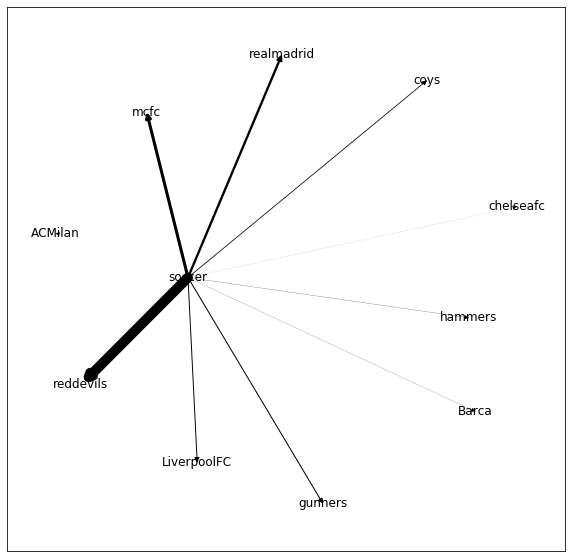

In [22]:
m=max(dict_weight.values())
G = nx.DiGraph()
weights = []
for k in dict_weight:
    w=(dict_weight[k]/m)*10
    if w<0.0001:
        w=0.001
    G.add_edge('soccer', k, weight=w)
    weights.append(w)
pylab.figure(1,figsize=(10,10))
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw_networkx(G, pos,width=weights, node_size=0)
plt.show()

In [35]:
# Do the above procedure for 10 subreddits. 
# So for each community, conflicts with other 9 communities are analyzed through this graph
# Takes some time to run
from itertools import permutations

subreddit = dict()
subreddit_comments = dict()
subreddit_list = list(keywords_dictionary.keys())
pairs_list = permutations(subreddit_list,2)
for i, df_month in enumerate(RC_2017_LIST):
    for sub_r in keywords_dictionary:
        subreddit[sub_r] = df_month[df_month["subreddit"]==sub_r]
        if(i==0):
            subreddit_comments[sub_r] = sub[sub_r]
        else:
            subreddit_comments[sub_r] = subreddit_comments[sub_r].append(subreddit[sub_r])
            
            
dict_weight2 = dict()            
for subr_A,subr_B in pairs_list:
    print(subr_A, subr_B)
    sum1 = 0
    for i, body in enumerate(list(sub_comments[subr_A]["body"])):
        keyword_count = 0
        for keyword in " ".join(keywords_dictionary[subr_B]).split(" "):
            if(type(body)==str and keyword.lower() in body.lower()):
                keyword_count+=1
        if(keyword_count >= 8):
            if TextBlob(body).sentiment.polarity<0:
                sum1 += abs(TextBlob(body).sentiment.polarity*keyword_count)
            sentiment = TextBlob(body)
    if sum1<0:
        sum1 = sum1*-1
    t = (subr_A, subr_B)
    if sum1 !=0:
        dict_weight2[t] = sum1
print(dict_weight2)

LiverpoolFC chelseafc
LiverpoolFC Barca
LiverpoolFC realmadrid
LiverpoolFC ACMilan
LiverpoolFC reddevils
LiverpoolFC mcfc
LiverpoolFC gunners
LiverpoolFC hammers
LiverpoolFC coys
chelseafc LiverpoolFC
chelseafc Barca
chelseafc realmadrid
chelseafc ACMilan
chelseafc reddevils
chelseafc mcfc
chelseafc gunners
chelseafc hammers
chelseafc coys
Barca LiverpoolFC
Barca chelseafc
Barca realmadrid
Barca ACMilan
Barca reddevils
Barca mcfc
Barca gunners
Barca hammers
Barca coys
realmadrid LiverpoolFC
realmadrid chelseafc
realmadrid Barca
realmadrid ACMilan
realmadrid reddevils
realmadrid mcfc
realmadrid gunners
realmadrid hammers
realmadrid coys
ACMilan LiverpoolFC
ACMilan chelseafc
ACMilan Barca
ACMilan realmadrid
ACMilan reddevils
ACMilan mcfc
ACMilan gunners
ACMilan hammers
ACMilan coys
reddevils LiverpoolFC
reddevils chelseafc
reddevils Barca
reddevils realmadrid
reddevils ACMilan
reddevils mcfc
reddevils gunners
reddevils hammers
reddevils coys
mcfc LiverpoolFC
mcfc chelseafc
mcfc Barca
mcf

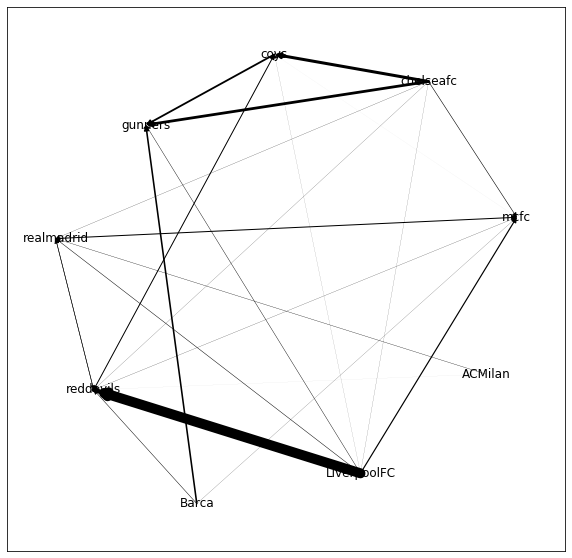

In [36]:
# Plot the conflict graph with edges weighted with conflict intensity
# The graph shown below is taking only negative sentiment comments, 
# The one in the slides takes sentiment <= 0.2, which won't be wrong as keywords are also taken into consideration

G = nx.DiGraph()
m = max(dict_weight2.values())
weights = []
for t in dict_weight2:
    w=(dict_weight2[t]/m)*10
    G.add_edge(t[0], t[1], weight=w)
    weights.append(w)
pylab.figure(1,figsize=(10,10))
pos = nx.spring_layout(G,k=50)  # positions for all nodes
nx.draw_networkx(G, pos,width=weights, node_size=0)
plt.show()


# As we can see, and is quite known, reddevils (Manchester United) and LiverpoolFC have the highest conflict intensity 
# for 2017. This could be attributed to them having the most fans (most activity wrt comments, unique users)
# Also the UEFA champions league had spiked the activity relatively, which increased the probability of conflict

In [51]:
s='\n The graph details: '
print (s)


a=G.number_of_nodes()
s='\n The no of nodes: ' +repr(a)
a=G.number_of_nodes()
s='\n The no of nodes: ' +repr(a)
a=G.number_of_nodes()
s='\n The no of nodes: ' +repr(a)
print (s)
a= G.number_of_edges()
s='\n The no of edges: ' +repr(a)
print (s)

deg=nx.degree(G)
a= min(deg)
s='\n The min degree: ' +repr(a)
print (s)

a = max(deg)
s='\n The max degree: ' +repr(a)
print (s)

a= G.number_of_edges()
s='\n The no of edges: ' +repr(a)
print (s)


max(G, key=G.degree)


 The graph details: 

 The no of nodes: 10

 The no of edges: 56

 The min degree: ('ACMilan', 8)

 The max degree: ('reddevils', 14)

 The no of edges: 56


'LiverpoolFC'

In [52]:
#DEGREE CENTRALITY
from operator import itemgetter
degc = nx.degree_centrality(G)
sorted(degc.items(), key=itemgetter(1), reverse=True)

[('LiverpoolFC', 1.5555555555555554),
 ('chelseafc', 1.5555555555555554),
 ('realmadrid', 1.5555555555555554),
 ('reddevils', 1.5555555555555554),
 ('coys', 1.5555555555555554),
 ('Barca', 1.4444444444444444),
 ('ACMilan', 0.8888888888888888),
 ('mcfc', 0.7777777777777777),
 ('gunners', 0.7777777777777777),
 ('hammers', 0.7777777777777777)]

In [54]:
#CLOSENESS CENTRALITY
clos = nx.closeness_centrality(G)
# let's list the scores
sorted(clos.items(), key=itemgetter(1), reverse=True)

[('mcfc', 0.7777777777777778),
 ('gunners', 0.7777777777777778),
 ('hammers', 0.7777777777777778),
 ('LiverpoolFC', 0.6666666666666666),
 ('realmadrid', 0.6666666666666666),
 ('reddevils', 0.6666666666666666),
 ('coys', 0.6666666666666666),
 ('chelseafc', 0.5714285714285714),
 ('Barca', 0.5714285714285714),
 ('ACMilan', 0.3636363636363636)]

In [ ]:
## Using this conflict graph, we can answer speciﬁc questions :

#### 1. Which subreddits are most often instigators of conﬂict (versus targets) ?
####        The closeness centrality tells us that mcfc, gunners, 
####         hammers are close to all the other subreddits in terms of conflict
#### 2. Are conﬂicts reciprocal and are they proportional in intensity ?
####    We infer from the graph, that conflicts between communities are reciprocal most of the time
####    But the intensity does not need not be the same. The weights of the edges in the graph tell the intensity of the graph
#### 3. Does 'attacking' multiple subreddits imply broad member misbehavior or the work of just a few individuals ? 
####    The weight of the edges suggest that many members are usually involved in the conflict. 
####    We have not analysed who starts / joins the conflict
#### 4. Do conﬂicts shift over time - not done. Did one analysis for a year. Not month by month